In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from pyomo.environ import *
import numpy as np
from sympy import symbols
import seaborn as sns
import pandas as pd

# **First step: finding background traffic**

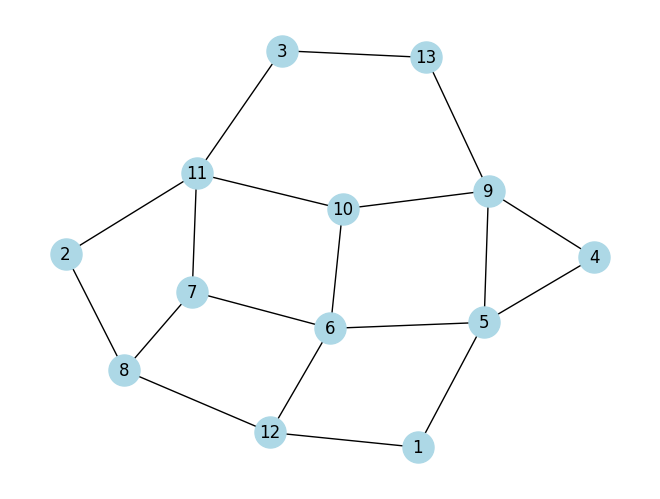

Paths for w_1:
  w_1_p_1: [1, 12, 8, 2]
    Links: ['edge_1_12', 'edge_12_8', 'edge_8_2']
Paths for w_2:
  w_2_p_1: [1, 5, 6, 7, 11, 3]
    Links: ['edge_1_5', 'edge_5_6', 'edge_6_7', 'edge_7_11', 'edge_11_3']
  w_2_p_2: [1, 12, 6, 10, 11, 3]
    Links: ['edge_1_12', 'edge_12_6', 'edge_6_10', 'edge_10_11', 'edge_11_3']
  w_2_p_3: [1, 12, 6, 7, 11, 3]
    Links: ['edge_1_12', 'edge_12_6', 'edge_6_7', 'edge_7_11', 'edge_11_3']
  w_2_p_4: [1, 5, 9, 13, 3]
    Links: ['edge_1_5', 'edge_5_9', 'edge_9_13', 'edge_13_3']
  w_2_p_5: [1, 5, 6, 10, 11, 3]
    Links: ['edge_1_5', 'edge_5_6', 'edge_6_10', 'edge_10_11', 'edge_11_3']
Paths for w_3:
  w_3_p_1: [4, 5, 6, 7, 8, 2]
    Links: ['edge_4_5', 'edge_5_6', 'edge_6_7', 'edge_7_8', 'edge_8_2']
  w_3_p_2: [4, 9, 10, 11, 2]
    Links: ['edge_4_9', 'edge_9_10', 'edge_10_11', 'edge_11_2']
Paths for w_4:
  w_4_p_1: [4, 5, 6, 7, 11, 3]
    Links: ['edge_4_5', 'edge_5_6', 'edge_6_7', 'edge_7_11', 'edge_11_3']
  w_4_p_2: [4, 9, 13, 3]
    Links: ['edge_

In [ ]:

# Initialize the graph and other variables
G = nx.Graph()
nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
edges_with_distances = [
    (1, 5, 7),   # Node 1 to Node 5 with travel time 7
    (1, 12, 9),  # Node 1 to Node 12 with travel time 9
    (12, 6, 7),  # Node 12 to Node 6 with travel time 7
    (12, 8, 14), # Node 12 to Node 8 with travel time 14
    (5, 6, 3),   # Node 5 to Node 6 with travel time 3
    (5, 9, 9),   # Node 5 to Node 9 with travel time 9
    (6, 7, 5),   # Node 6 to Node 7 with travel time 5
    (6, 10, 13), # Node 6 to Node 10 with travel time 13
    (7, 8, 5),   # Node 7 to Node 8 with travel time 5
    (7, 11, 9),  # Node 7 to Node 11 with travel time 9
    (8, 2, 9),   # Node 8 to Node 2 with travel time 9
    (9, 10, 10), # Node 9 to Node 10 with travel time 10
    (9, 13, 9),  # Node 9 to Node 13 with travel time 9
    (10, 11, 6), # Node 10 to Node 11 with travel time 6
    (13, 3, 3),  # Node 13 to Node 3 with travel time 3
    (4, 5, 9),   # Node 4 to Node 5 with travel time 9
    (4, 9, 12),
    (11, 3, 8),
    (11, 2, 9),
]
population = 100
W = [(1, 2), (1, 3), (4, 2), (4, 3)]  # Example list of node pairs

# Predefined paths for W
predefined_paths_for_w = {
    (1, 2): [[1, 12, 8, 2]],
    (1, 3): [
        [1, 5, 6, 7, 11, 3],
        [1, 12, 6, 10, 11, 3],
        [1, 12, 6, 7, 11, 3],
        [1, 5, 9, 13, 3],
        [1, 5, 6, 10, 11, 3]
    ],
    (4, 2): [
        [4, 5, 6, 7, 8, 2],
        [4, 9, 10, 11, 2]
    ],
    (4, 3): [
        [4, 5, 6, 7, 11, 3],
        [4, 9, 13, 3]
    ]
}

# Add nodes to the graph
G.add_nodes_from(nodes)

edge_names = {}  # Dictionary to hold edge names

# Add edges to the graph
for u, v, distance in edges_with_distances:
    G.add_edge(u, v, distance=distance)

    # Assign edge names with direction indicators
    edge_name_uv = f'edge_{u}_{v}'
    edge_name_vu = f'edge_{v}_{u}'
    edge_names[(u, v)] = edge_name_uv
    edge_names[(v, u)] = edge_name_vu  # Assigning different names for reverse edge

# Map W to names
W_named = {f'w_{i+1}': W[i] for i in range(len(W))}

# Initialize the dictionaries to hold paths and links
generated_paths = {}  # This will have keys W_named and path_name
path_links = {}       # This will have keys W_named and path_name

# Dictionary to store gamma for each origin-destination pair in W
gamma = {}
# Dictionary to store distances for each link
d_l = {}
k_l = {}

# Define distance (d_l) and capacity parameter (k_l) for each edge
for u, v, data in G.edges(data=True):
    edge_name_uv = edge_names[(u, v)]
    edge_name_vu = edge_names[(v, u)]

    # Assign d_l and k_l values for each direction of the edge
    d_l[edge_name_uv] = data['distance']
    d_l[edge_name_vu] = data['distance']  # Assuming distance is the same in both directions
    k_l[edge_name_uv] = random.uniform(0.02, 0.02)
    k_l[edge_name_vu] = random.uniform(0.02, 0.02)

# Use predefined paths instead of nx.all_simple_paths
for name, (origin, destination) in W_named.items():
    gamma[name] = population  # Define gamma values for each origin-destination pair in W_named

    predefined_paths = predefined_paths_for_w.get((origin, destination), [])

    # Create a dictionary entry for the paths and links of this specific W pair
    generated_paths[name] = {}  # Store paths by name under each W pair
    path_links[name] = {}       # Store links for each path under the corresponding W pair

    # Save predefined path details and links
    for path_counter, path in enumerate(predefined_paths, start=1):
        path_name = f'{name}_p_{path_counter}'

        # Store the predefined path under the corresponding W pair and path name
        generated_paths[name][path_name] = path

        # Initialize list for links in the path
        path_links_for_path = []
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edge_name = edge_names[(u, v)]
            path_links_for_path.append(edge_name)

        # Store the links under the corresponding W pair and path name
        path_links[name][path_name] = path_links_for_path

# Optional: Visualize the graph with edge names
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue')

# Draw edge labels including the names
edge_labels = {(u, v): G.edges[(u, v)].get('name', '') for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

# Example of accessing the saved paths and links
for w_name in generated_paths:
    print(f"Paths for {w_name}:")
    for path_name, path in generated_paths[w_name].items():
        print(f"  {path_name}: {path}")
        print(f"    Links: {path_links[w_name][path_name]}")


In [ ]:


#def run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T):
lambda_1 = 1

    # Collect all unique s(p) values
  # Define the model
model = ConcreteModel()

# Define the model variables
model.q = Var(((omega, path_name) for omega in W_named for path_name in generated_paths[omega]), within=NonNegativeReals, initialize=0)
# Define the objective function
def objective_function(model):
    objective_value = 0.0
    for omega in W_named:
        for path_name, path in generated_paths[omega].items():
            links = path_links[omega][path_name]

            term1 = sum(
                lambda_1 * d_l[l] * k_l[l] * (1+
                      # Include the base gamma_0_l
                    sum(
                        gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                        for omega_prime in W_named
                        for p_prime, p_path in generated_paths[omega_prime].items()
                        if l in path_links[omega_prime][p_prime]
                    ) +  # Include the gamma for current O-D pair
                    sum(
                        (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                        for p_prime in generated_paths[omega]
                        if l in path_links[omega][p_prime]
                    )
                )
                for l in links
            )


            objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1)

    return objective_value

model.objective = Objective(rule=objective_function, sense=minimize)

# Constraints

def q_constraint_rule(model, omega):
    return sum(model.q[(omega, path_name)] for path_name in generated_paths[omega]) == 1

model.q_constraint = Constraint(W_named, rule=q_constraint_rule)



model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in generated_paths[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)

def path_comparison_constraint(model, omega, m, h):
    path_m = generated_paths[omega][m]
    path_h = generated_paths[omega][h]

    left_side = (
  (
        sum(
                lambda_1 * d_l[l] * k_l[l] * (1+
                    sum(
                        gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                        for omega_prime in W_named
                        for p_prime, p_path in generated_paths[omega_prime].items()
                        if l in path_links[omega_prime][p_prime]
                    ) +  # Include the gamma for current O-D pair
                    sum(
                        (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                        for p_prime in generated_paths[omega]
                        if l in path_links[omega][p_prime]
                    )
                )
                for l in path_links[omega][h]
            )
    )
    )
    right_side = (
     (
                sum(
                lambda_1 * d_l[l] * k_l[l] * (1+

                    sum(
                        gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                        for omega_prime in W_named
                        for p_prime, p_path in generated_paths[omega_prime].items()
                        if l in path_links[omega_prime][p_prime]
                    ) +  # Include the gamma for current O-D pair
                    sum(
                        (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                        for p_prime in generated_paths[omega]
                        if l in path_links[omega][p_prime]
                    )
                )
                for l in path_links[omega][m]
            )
    )
    )

    return model.q[(omega, m)] * right_side <= model.q[(omega, m)] * left_side

model.path_comparison_constraint = Constraint(((omega, m, h) for omega in W_named for m in generated_paths[omega] for h in generated_paths[omega] if m != h), rule=path_comparison_constraint)

# Solve the model
solver = SolverFactory('ipopt')
solver.options['max_iter'] = 100000
results = solver.solve(model, tee=True)
    # Output the results
print(f"Status: {results.solver.status}")
print(f"Objective value: {model.objective()}")
for v in model.component_objects(Var, active=True):
    varobject = getattr(model, str(v))
    for index in varobject:
        print(f"{str(v)}[{index}] = {varobject[index].value}")

Ipopt 3.13.2: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computat

In [ ]:
# Dictionary to store population on each link
link_population = {}

# Iterate over each origin-destination pair (W_named) and paths
for w_name, paths in generated_paths.items():
    # Get the gamma (population) for the current origin-destination pair
    gamma_w = gamma[w_name]

    # For each path under the current origin-destination pair
    for path_name, path in paths.items():
        # Get the relative q (flow) for the current path from the optimization results
        q_value = model.q[(w_name, path_name)].value  # Extract q value from the optimization model

        # Calculate the population on this path (gamma_w * q_value)
        path_population = gamma_w * q_value

        # Get the links for the current path
        links_in_path = path_links[w_name][path_name]

        # Distribute the path population to each link in the path
        for link in links_in_path:
            if link not in link_population:
                link_population[link] = 0  # Initialize if the link is not yet added
            link_population[link] += path_population  # Add the path population to the link

# Output the population on each link
print("Population on each link:")
for link, pop in link_population.items():
    print(f"{link}: {pop} people")


Population on each link:
edge_1_12: 120.05893305390718 people
edge_12_8: 100.0 people
edge_8_2: 148.30205408547408 people
edge_1_5: 79.94106694609282 people
edge_5_6: 115.23856751327327 people
edge_6_7: 107.57215548031775 people
edge_7_11: 59.270101394843664 people
edge_11_3: 86.99544648170635 people
edge_12_6: 20.05893305390718 people
edge_6_10: 27.72534508686269 people
edge_10_11: 79.4232910013886 people
edge_5_9: 51.19303276745553 people
edge_9_13: 113.00455351829366 people
edge_13_3: 113.00455351829366 people
edge_4_5: 86.49053333463596 people
edge_7_8: 48.30205408547408 people
edge_4_9: 113.50946666536404 people
edge_9_10: 51.69794591452591 people
edge_11_2: 51.69794591452591 people


In [ ]:
edges_with_distances = [
    (1, 5, 7, 'X'),   # Node 1 to Node 5 with travel time 7
    (1, 12, 9, 'X'),  # Node 1 to Node 12 with travel time 9
    (12, 6, 7, 'X'),  # Node 12 to Node 6 with travel time 7
    (12, 8, 14, 'X'), # Node 12 to Node 8 with travel time 14
    (5, 6, 3, 'X'),   # Node 5 to Node 6 with travel time 3
    (5, 9, 9, 'X'),   # Node 5 to Node 9 with travel time 9
    (6, 7, 5, 'X'),   # Node 6 to Node 7 with travel time 5
    (6, 10, 13, 'X'), # Node 6 to Node 10 with travel time 13
    (7, 8, 5, 'X'),   # Node 7 to Node 8 with travel time 5
    (7, 11, 9, 'X'),  # Node 7 to Node 11 with travel time 9
    (8, 2, 9, 'X'),   # Node 8 to Node 2 with travel time 9
    (9, 10, 10, 'X'), # Node 9 to Node 10 with travel time 10
    (9, 13, 9, 'X'),  # Node 9 to Node 13 with travel time 9
    (10, 11, 6, 'X'), # Node 10 to Node 11 with travel time 6
    (13, 3, 3, 'X'),  # Node 13 to Node 3 with travel time 3
    (4, 5, 9, 'X'),   # Node 4 to Node 5 with travel time 9
    (4, 9, 12, 'X'),  # Node 4 to Node 9 with travel time 12
    (11, 3, 8, 'X'),  # Node 11 to Node 3 with travel time 8
    (11, 2, 9, 'X'),  # Node 11 to Node 2 with travel time 9
]

# Step 1: Create a dictionary that holds the population for each edge in both directions

# Step 2: Update edges_with_distances by replacing 'X' with the population

updated_edges_with_population = []

for (u, v, distance, _) in edges_with_distances:
    # Fetch population for both directions of the edge
    edge_name_uv = f"edge_{u}_{v}"
    edge_name_vu = f"edge_{v}_{u}"

    # Get the population for this edge from the dictionary, or 0 if not present
    population_uv = link_population.get(edge_name_uv, 0)
    population_vu = link_population.get(edge_name_vu, 0)

    # Total population on this link in both directions
    total_population = population_uv + population_vu

    # Append the updated edge info with the population
    updated_edges_with_population.append((u, v, distance, np.round(total_population)))

# Step 3: Output the updated edges_with_distances list
print("Updated edges with population:")
for edge in updated_edges_with_population:
    print(edge)


Updated edges with population:
(1, 5, 7, np.float64(80.0))
(1, 12, 9, np.float64(120.0))
(12, 6, 7, np.float64(20.0))
(12, 8, 14, np.float64(100.0))
(5, 6, 3, np.float64(115.0))
(5, 9, 9, np.float64(51.0))
(6, 7, 5, np.float64(108.0))
(6, 10, 13, np.float64(28.0))
(7, 8, 5, np.float64(48.0))
(7, 11, 9, np.float64(59.0))
(8, 2, 9, np.float64(148.0))
(9, 10, 10, np.float64(52.0))
(9, 13, 9, np.float64(113.0))
(10, 11, 6, np.float64(79.0))
(13, 3, 3, np.float64(113.0))
(4, 5, 9, np.float64(86.0))
(4, 9, 12, np.float64(114.0))
(11, 3, 8, np.float64(87.0))
(11, 2, 9, np.float64(52.0))


### **Using background traffic for the Charging game**

In [ ]:
#build the network and virtual nodes

def create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population, predefined_paths_for_w, E, t):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(nodes)

    edge_names = {}  # Dictionary to hold edge names
    e = {}  # Electricity tariff
    N_star = []  # Virtual nodes (charging stations)
    T={}

    # Add edges to the graph
    for u, v, distance, demand in edges_with_distances:
        G.add_edge(u, v, distance=distance, demand=demand)
        G.add_edge(v, u, distance=distance, demand=demand)  # Adding a second edge in reverse direction

        # Assign edge names with direction indicators
        edge_name_uv = f'edge_{u}_{v}'
        edge_name_vu = f'edge_{v}_{u}'
        edge_names[(u, v)] = edge_name_uv
        edge_names[(v, u)] = edge_name_vu  # Assigning different names for reverse edge

    # Add new nodes (e.g., 1* for node 1) and connect them to their corresponding original nodes
    for node in nodes:
      if node in [ 9,7,
          1,2,3,4,5,6,8,10,13,
                  11,12]:
        new_node = f'{node}*'
        G.add_node(new_node)
        edge_name_node_nodestar = f'edge_{node}_{node}*'
        edge_name_node_nodestar_2 = f'edge_{node}*_{node}'
        G.add_edge(new_node, node, distance=0, demand=0, name=edge_name_node_nodestar_2)
        G.add_edge(node, new_node, distance=0, demand=0, name=edge_name_node_nodestar)  # Adding reverse edge with the same name
        edge_names[(new_node, node)] = edge_name_node_nodestar_2
        edge_names[(node, new_node)] = edge_name_node_nodestar
        e[new_node] = E[(nodes.index(node))]
        T[new_node]= t[(nodes.index(node))]
        N_star.append(new_node)

    # Map W to names
    W_named = {f'w_{i+1}': W[i] for i in range(len(W))}

    paths = {}
    path_names = {}  # Dictionary to hold path names

    # Dictionary to store links for each path
    links = {}
    # Dictionary to store gamma for each origin-destination pair in W
    gamma = {}
    # Dictionary to store background traffic
    gamma_0_l = {}
    # Dictionary to store distances for each link
    d_l = {}
    k_l = {}

    # Define converse of road capacity (gamma^0_l) for each edge
    for u, v, data in G.edges(data=True):
        edge_name_uv = edge_names[(u, v)]
        edge_name_vu = edge_names[(v, u)]

        # Assign gamma^0_l, d_l, and k_l values for each direction of the edge
        d_l[edge_name_uv] = data['distance']
        d_l[edge_name_vu] = data['distance']  # Assuming distance is the same in both directions
        k_l[edge_name_uv] = random.uniform(0.02, 0.02)
        k_l[edge_name_vu] = random.uniform(0.02, 0.02)
        gamma_0_l[edge_name_uv] = data['demand']
        gamma_0_l[edge_name_vu] = data['demand']

    # Find all paths for each named pair in W_named
    path_counter = 1
    for name, (origin, destination) in W_named.items():
        gamma[name] = population * charge_rate  # Define gamma values for each named pair

        # Use predefined paths for each (origin, destination) pair, if available
        path_list = predefined_paths_for_w.get((origin, destination), [])

        for path in path_list:
            # Assign a unique name to each path
            path_name = f'p_{path_counter}'
            path_counter += 1
            path_names[tuple(path)] = path_name

            # Initialize list for links in the path
            path_links = []
            for i in range(len(path) - 1):
                u = path[i]
                v = path[i + 1]
                edge_name = edge_names.get((u, v), '')  # Use get to avoid KeyError
                if edge_name:
                    path_links.append(edge_name)
            links[path_name] = path_links

    # Function to expand paths with star nodes
    def expand_paths_with_one_star(paths, G, W_named):
      expanded_paths = {}
      path_counter = 0  # Counter to generate unique names

      # Reverse mapping from paths to W_named keys
      reverse_mapping = {path: name for name, (path) in W_named.items()}

      for (origin, destination), path_list in paths.items():
          w_name = reverse_mapping.get((origin, destination), f'w_{path_counter}')
          if w_name not in expanded_paths:
              expanded_paths[w_name] = {}

          for path in path_list:
              # Generate expanded paths with star nodes
              for i in range(len(path) + 1):
                  expanded_path = []
                  for j in range(i):
                      expanded_path.append(path[j])
                  if i < len(path):
                      node = path[i]
                      if f'{node}*' in G.nodes:
                          expanded_path.append(node)
                          expanded_path.append(f'{node}*')
                  if i < len(path):
                      expanded_path.append(path[i])
                  for j in range(i + 1, len(path)):
                      expanded_path.append(path[j])

                  # Ensure the path starts at origin and ends at destination
                  if expanded_path[0] != origin:
                      expanded_path = [origin] + expanded_path[1:]
                  if expanded_path[-1] != destination:
                      expanded_path = expanded_path[:-1] + [destination]

                  # Ensure the path contains at least one star node
                  if any('*' in str(node) for node in expanded_path):
                      path_name = f'path_{path_counter}'
                      expanded_paths[w_name][path_name] = expanded_path
                      path_counter += 1

      return expanded_paths

    # Function to generate links from a path
    def generate_links_from_path(path):
        return [edge_names.get((path[i], path[i + 1]), '') for i in range(len(path) - 1)]

    # Function to generate links for named paths
    def generate_links_for_paths(expanded_paths):
        path_links = {}

        for key, named_paths in expanded_paths.items():
            path_links[key] = {}

            for path_name, path in named_paths.items():
                path_links[key][path_name] = generate_links_from_path(path)

        return path_links

    # Expand the paths with one star and assign names
    expanded_paths_with_one_star = expand_paths_with_one_star(predefined_paths_for_w, G, W_named)

    # Generate links for each named path
    path_links = generate_links_for_paths(expanded_paths_with_one_star)

    # Print the expanded paths and their links
    print("Expanded Paths with One Star:")
    for key, named_paths in expanded_paths_with_one_star.items():
        print(f"{key}:")
        for name, path in named_paths.items():
            print(f"  {name}: {path}")

    print("\nLinks for Each Named Path:")
    for key, named_paths in path_links.items():
        print(f"{key}:")
        for name, link_list in named_paths.items():
            print(f"  {name}: {link_list}")

    # Optional: To visualize the graph with edge names
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue')

    # Draw edge labels including the names
    edge_labels = {(u, v): G.edges[(u, v)].get('name', '') for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

    # Return generated data for further use
    return {
        'graph': G,
        'expanded_paths_with_one_star': expanded_paths_with_one_star,
        'path_links': path_links,
        'edge_names': edge_names,
        'gamma': gamma,
        'gamma_0_l': gamma_0_l,
        'd_l': d_l,
        'k_l': k_l,
        'e': e,
        'N_star': N_star,
        'W_named': W_named,
        'T': T
    }


In [ ]:
#the function that solves the NLP, returns real values for x

def run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T):
    # Define the s(p) function
    def s(path_name, expanded_paths_with_one_star):
        for key, path_dict in expanded_paths_with_one_star.items():
            if path_name in path_dict:
                path = path_dict[path_name]
                for node in path:
                    if '*' in str(node):
                        return node
        return None

    # Collect all unique s(p) values
    s_p_set = {s(p_prime, expanded_paths_with_one_star) for omega in W_named for p_prime in expanded_paths_with_one_star[omega].keys()}

    # Define the model
    model = ConcreteModel()

    # Define the model variables
    model.q = Var(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), within=NonNegativeReals, initialize=0) #strategies for each path of a origin-destination
    model.x = Var((s_p for s_p in s_p_set if s_p is not None), within=NonNegativeIntegers, initialize=0) #Number of chargers at charging station
    model.y = Var((s_p for s_p in s_p_set if s_p is not None), within=NonNegativeReals, initialize=0) #price of charging at each station

    # Define the objective function- social cost
    def objective_function(model):
        objective_value = 0.0
        for omega in W_named:
            for path_name, path in expanded_paths_with_one_star[omega].items():
                links = path_links[omega][path_name]

                term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in links
                )

                # Calculate term2 for the unique s(p) value
                s_p = s(path_name, expanded_paths_with_one_star)
                if s_p is not None:
                    term2 = lambda_2 * (
                        # First part: Sum for omega' != omega (different O-D pairs)
                        sum(
                            (gamma[omega_prime] * model.q[(omega_prime, p_prime)] / (mu * model.x[s_p] + 0.1))
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p and omega_prime != omega
                        )
                        # Second part: Sum for omega = omega (same O-D pair) with the +1 term
                        + sum(
                            ((gamma[omega] - 1) * model.q[(omega, p_prime)] / (mu * model.x[s_p] + 0.1))
                            for p_prime, p_path in expanded_paths_with_one_star[omega].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p
                        )
                        + 1  # The "+1" term that was missing earlier
                    )
                else:
                    term2 = 0

                term3 = lambda_3 * model.y[s(path_name, expanded_paths_with_one_star)]

                objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1 + term2+ term3)

        return objective_value

    model.objective = Objective(rule=objective_function, sense=minimize)

    # Constraints
    def budget_constraint(model):
        return sum(model.x[s_p] for s_p in s_p_set if s_p is not None) <= B

    model.budget_constraint = Constraint(rule=budget_constraint)

    def q_constraint_rule(model, omega):
        return sum(model.q[(omega, path_name)] for path_name in expanded_paths_with_one_star[omega]) == 1

    model.q_constraint = Constraint(W_named, rule=q_constraint_rule)

    # Extract unique s(p) values
    unique_s_p_values = set()
    for omega in W_named:
        for path_name in expanded_paths_with_one_star[omega]:
            s_p = s(path_name, expanded_paths_with_one_star)
            if s_p is not None:
                unique_s_p_values.add(s_p)

    #Define the cost constraint function
    def cost_constraint(model, s_p):
        lhs = sum(gamma[omega_prime] * model.q[(omega_prime, p_prime)] * e[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p) + (1.2*T[s_p]*model.x[s_p])

        rhs = sum((gamma[omega_prime] * model.q[(omega_prime, p_prime)]) * model.y[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p)

        return lhs <= rhs

    #Create constraints for each unique s(p) value
    model.cost_constraints = Constraint(unique_s_p_values, rule=cost_constraint)

    model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)


    # model.path_comparison_constraint = Constraint(((omega, m, h) for omega in W_named for m in expanded_paths_with_one_star[omega] for h in expanded_paths_with_one_star[omega] if m != h), rule=path_comparison_constraint)
    def path_comparison_constraint(model, omega, m, h):
        # Define terms for the left-hand side (h path)
        # lhs_term1 = sum(
        #     d_l[l] * k_l[l] * (sum(gamma[omega_prime] * model.q[(omega_prime, h_prime)]
        #                            for omega_prime in W_named
        #                            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
        #                            if l in path_links[omega_prime][h_prime]) + gamma_0_l[l])
        #     for l in path_links[omega][h]
        # )
        lhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][h]
                )

        lhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for h_prime, h_path in expanded_paths_with_one_star[omega].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star)
        ) + 1

        lhs_term3 = model.y[s(h, expanded_paths_with_one_star)]

        lhs =  (lambda_1 * lhs_term1 + lambda_2 * lhs_term2 + lambda_3 * lhs_term3)

        # Define terms for the right-hand side (m path)
        rhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][m]
                )
        rhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, m_prime)] /
            (mu * model.x[s(m_prime, expanded_paths_with_one_star)] + 0.01)
            for m_prime, m_path in expanded_paths_with_one_star[omega].items()
            if s(m_prime, expanded_paths_with_one_star) == s(m, expanded_paths_with_one_star)
        ) + 1
        rhs_term3 = model.y[s(m, expanded_paths_with_one_star)]

        rhs =  (lambda_1 * rhs_term1 + lambda_2 * rhs_term2 + lambda_3 * rhs_term3)

        # Constraint: lhs >= rhs
        return model.q[(omega, m)] * lhs >= model.q[(omega, m)] *rhs

    model.path_comparison_constraint = Constraint(
        ((omega, m, h) for omega in W_named
         for m in expanded_paths_with_one_star[omega]
         for h in expanded_paths_with_one_star[omega]
         if m != h),
        rule=path_comparison_constraint
    )
    # Solve the model
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = 100000
    results = solver.solve(model, tee=True)
        # Output the results
    print(f"Status: {results.solver.status}")
    print(f"Objective value: {model.objective()}")
    for v in model.component_objects(Var, active=True):
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"{str(v)}[{index}] = {varobject[index].value}")

    # Rounding the x values
    x_values = {}

    # Iterate over the variables in the model and store the values of variable x in the dictionary
    for v in model.component_objects(Var, active=True):
        if str(v) == 'x':  # Check if the variable is 'x'
            varobject = getattr(model, str(v))
            for index in varobject:
                x_values[index] = varobject[index].value
    #Adjust X values
    def adjust_x_values_dict(x_values):
    # Step 1: Sort the dictionary items by the fractional part of their values in descending order
      sorted_items = sorted(x_values.items(), key=lambda item: item[1] - int(item[1]), reverse=True)

    # Step 2: Floor all the values and calculate the initial sum
      floored_values = {key: int(value) for key, value in sorted_items}
      initial_sum = sum(floored_values.values())
      Z= sum(x_values.values())

    # Step 3: Calculate the difference between B and the initial sum
      difference = Z - initial_sum

    # Step 4: Increment the values with the highest fractional parts
      for i in range(int(round(difference))):
        key = sorted_items[i][0]
        floored_values[key] += 1

      return floored_values
    x_values_adjusted = adjust_x_values_dict(x_values)

    # Deleting components
    if hasattr(model, 'x'):
        model.del_component(model.x)
    if hasattr(model, 'q'):
        model.del_component(model.q)
    if hasattr(model, 'y'):
        model.del_component(model.y)

    return x_values_adjusted  #x values are obtained


In [ ]:

#now we have values for x, we solve the model to get prices and strategies
def run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted):
    def s(path_name, expanded_paths_with_one_star):
        for key, path_dict in expanded_paths_with_one_star.items():
            if path_name in path_dict:
                path = path_dict[path_name]
                for node in path:
                    if '*' in str(node):
                        return node
        return None

    s_p_set = {s(p_prime, expanded_paths_with_one_star) for omega in W_named for p_prime in expanded_paths_with_one_star[omega].keys()}
    model = ConcreteModel()

    # Define the model variables
    model.q = Var(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), within=NonNegativeReals, initialize=0)
    model.y = Var((s_p for s_p in s_p_set if s_p is not None), within=NonNegativeReals, initialize=0)

    # Define the s(p) function


    # Define the objective function
    def objective_function(model):
        objective_value = 0.0
        for omega in W_named:
            for path_name, path in expanded_paths_with_one_star[omega].items():
                links = path_links[omega][path_name]

                # First term in the objective
                term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in links
                )
                # Second term in the objective
                s_p = s(path_name, expanded_paths_with_one_star)
                if s_p is not None:
                    term2 = lambda_2 * (
                        # First part: Sum for omega' != omega (different O-D pairs)
                        sum(
                            (gamma[omega_prime] * model.q[(omega_prime, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p and omega_prime != omega
                        )
                        # Second part: Sum for omega = omega (same O-D pair) with the +1 term
                        + sum(
                            ((gamma[omega] - 1) * model.q[(omega, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for p_prime, p_path in expanded_paths_with_one_star[omega].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p
                        )
                        + 1  # The "+1" term that was missing earlier
                    )
                else:
                    term2 = 0

                # Third term in the objective
                term3 = lambda_3 * model.y[s(path_name, expanded_paths_with_one_star)]

                # Adding terms to the objective function
                objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1 + term2+ term3)

        return objective_value

    model.objective = Objective(rule=objective_function, sense=minimize)

    #if the
    def conditional_q_constraint(model, omega, path_name):
        s_p = s(path_name, expanded_paths_with_one_star)  # Get the s_p value for the current path

        if s_p is not None and x_values_adjusted[s_p] == 0:
            return model.q[(omega, path_name)] == 0
        else:
            return Constraint.Skip  # Skip the constraint if x_values_adjusted[s_p] is not zero

    model.conditional_q_constraints = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=conditional_q_constraint)



    # Constraint: sum of q variables for each omega must equal 1
    def q_constraint_rule(model, omega):
        return sum(model.q[(omega, path_name)] for path_name in expanded_paths_with_one_star[omega]) == 1

    model.q_constraint = Constraint(W_named, rule=q_constraint_rule)


    # Extract unique s(p) values
    unique_s_p_values = set(x_values_adjusted.keys())

    # Define the cost constraint function
    def cost_constraint(model, s_p):
        lhs = sum(gamma[omega_prime] * model.q[(omega_prime, p_prime)] * e[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p) + (1.2*T[s_p]* x_values_adjusted[s_p])

        rhs = sum((gamma[omega_prime] * model.q[(omega_prime, p_prime)]) * model.y[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p)

        return lhs <= rhs

    # Apply the cost constraint to the model
    model.cost_constraints = Constraint(unique_s_p_values, rule=cost_constraint)

    # Ensure q values are non-negative
    model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)


    # model.path_comparison_constraint = Constraint(((omega, m, h) for omega in W_named for m in expanded_paths_with_one_star[omega] for h in expanded_paths_with_one_star[omega] if m != h), rule=path_comparison_constraint)
    def path_comparison_constraint(model, omega, m, h):
        # Define terms for the left-hand side (h path)
        lhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][h]
                )

        lhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for h_prime, h_path in expanded_paths_with_one_star[omega].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star)
        ) + 1

        lhs_term3 = model.y[s(h, expanded_paths_with_one_star)]

        lhs = (lambda_1 * lhs_term1 + lambda_2 * lhs_term2 + lambda_3 * lhs_term3)

        # Define terms for the right-hand side (m path)
        rhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][m]
                )
        rhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, m_prime)] /
            (mu * x_values_adjusted[s(m_prime, expanded_paths_with_one_star)] + 0.01)
            for m_prime, m_path in expanded_paths_with_one_star[omega].items()
            if s(m_prime, expanded_paths_with_one_star) == s(m, expanded_paths_with_one_star)
        ) + 1

        rhs_term3 = model.y[s(m, expanded_paths_with_one_star)]

        rhs = (lambda_1 * rhs_term1 + lambda_2 * rhs_term2 + lambda_3 * rhs_term3)

        # Constraint: lhs >= rhs
        return model.q[(omega, m)] * lhs >= model.q[(omega, m)] * rhs

    model.path_comparison_constraint = Constraint(
        ((omega, m, h) for omega in W_named
         for m in expanded_paths_with_one_star[omega]
         for h in expanded_paths_with_one_star[omega]
         if m != h),
        rule=path_comparison_constraint
    )
    # Solve the model
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = 100000
    results = solver.solve(model, tee=True)

    # Output the results
    print(f"Status: {results.solver.status}")
    for v in model.component_objects(Var, active=True):
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"{str(v)}[{index}] = {varobject[index].value}")
    print(x_values_adjusted)

    print(f"Objective value: {model.objective()}")
    y_values = {index: model.y[index].value for index in model.y}
    q_values = {(omega, path_name): model.q[(omega, path_name)].value for omega in W_named for path_name in expanded_paths_with_one_star[omega]}
    objective_value = model.objective()
    return objective_value, y_values, q_values





## **Model Nguyen and Dupuis**

Expanded Paths with One Star:
w_1:
  path_0: [1, 12, '12*', 12, 8, 2]
w_2:
  path_1: [1, 5, 6, 7, '7*', 7, 11, 3]
  path_2: [1, 5, 6, 7, 11, '11*', 11, 3]
  path_3: [1, 12, '12*', 12, 6, 10, 11, 3]
  path_4: [1, 12, 6, 10, 11, '11*', 11, 3]
  path_5: [1, 12, '12*', 12, 6, 7, 11, 3]
  path_6: [1, 12, 6, 7, '7*', 7, 11, 3]
  path_7: [1, 12, 6, 7, 11, '11*', 11, 3]
  path_8: [1, 5, 9, '9*', 9, 13, 3]
  path_9: [1, 5, 6, 10, 11, '11*', 11, 3]
w_3:
  path_10: [4, 5, 6, 7, '7*', 7, 8, 2]
  path_11: [4, 9, '9*', 9, 10, 11, 2]
  path_12: [4, 9, 10, 11, '11*', 11, 2]
w_4:
  path_13: [4, 5, 6, 7, '7*', 7, 11, 3]
  path_14: [4, 5, 6, 7, 11, '11*', 11, 3]
  path_15: [4, 9, '9*', 9, 13, 3]

Links for Each Named Path:
w_1:
  path_0: ['edge_1_12', 'edge_12_12*', 'edge_12*_12', 'edge_12_8', 'edge_8_2']
w_2:
  path_1: ['edge_1_5', 'edge_5_6', 'edge_6_7', 'edge_7_7*', 'edge_7*_7', 'edge_7_11', 'edge_11_3']
  path_2: ['edge_1_5', 'edge_5_6', 'edge_6_7', 'edge_7_11', 'edge_11_11*', 'edge_11*_11', 'edge_11

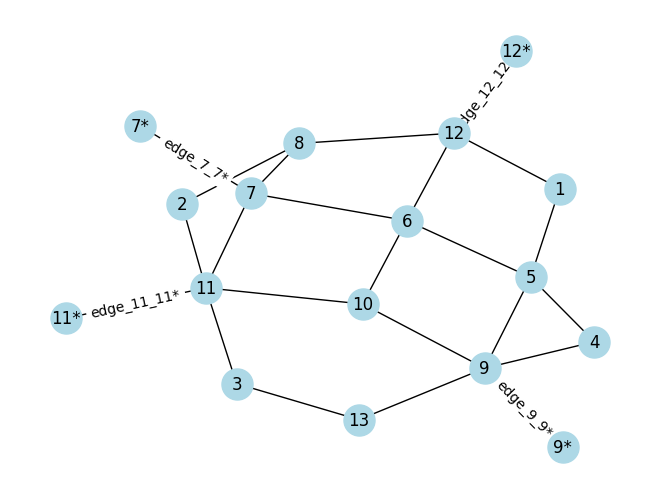

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

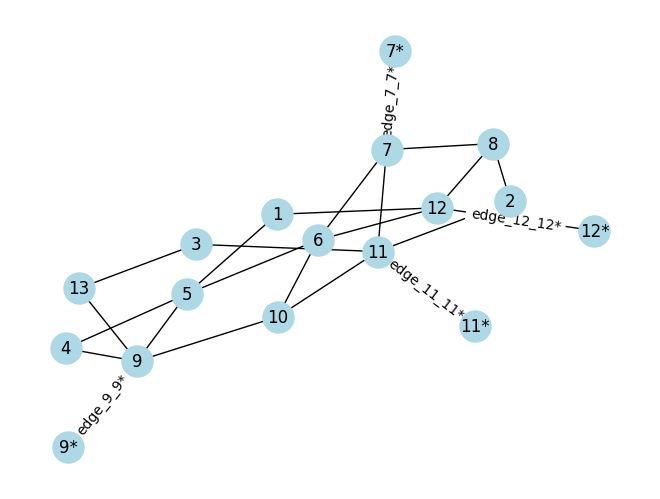

Streaming output truncated to the last 5000 lines.
2182  6.5087884e+03 8.98e-05 2.79e+07  -3.8 2.86e-02   2.5 7.75e-02 2.95e-01f  1
2183  6.5087876e+03 8.64e-05 2.78e+07  -3.8 4.51e-03   2.9 1.57e-02 3.72e-02h  2
2184  6.5087753e+03 8.12e-05 2.72e+07  -3.8 3.03e-03   3.4 1.91e-01 6.05e-02h  1
2185  6.5086199e+03 3.27e-05 1.79e+07  -3.8 3.87e-03   2.9 2.35e-01 6.00e-01f  1
2186  6.5081672e+03 2.13e-05 2.47e+07  -3.8 6.17e-03   3.3 9.95e-02 3.49e-01f  1
2187  6.5081552e+03 2.02e-05 2.18e+07  -3.8 1.35e-03   3.8 1.70e-01 5.33e-02f  1
2188  6.5080778e+03 2.25e-05 1.93e+07  -3.8 1.54e-02   3.3 5.98e-02 1.41e-01f  1
2189  6.5079178e+03 2.30e-06 5.40e+05  -3.8 1.66e-03   3.7 1.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190  6.5075428e+03 4.81e-05 3.44e+05  -3.8 1.05e-01   3.2 6.01e-02 6.32e-02f  1
2191  6.5074750e+03 2.37e-05 4.13e+05  -3.8 4.99e-03   2.7 1.29e-01 1.00e+00f  1
2192  6.5069071e+03 1.87e-05 4.10e+05  -3.8 1.99e-02   2.3

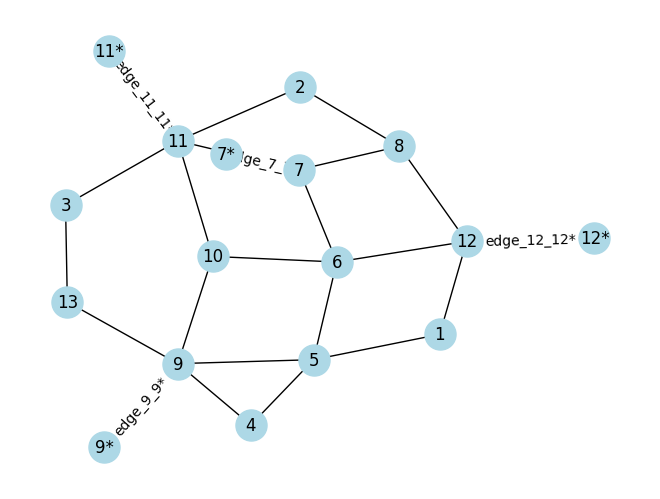

Streaming output truncated to the last 5000 lines.
2600  6.2481232e+03 3.41e-05 1.86e+04  -3.8 3.88e+00    -  1.31e-02 2.01e-02f  1
2601  6.2475793e+03 9.89e-04 2.98e+04  -3.8 1.68e+00    -  4.79e-02 4.13e-02f  1
2602  6.2475274e+03 9.82e-04 3.01e+04  -3.8 1.50e+00    -  1.57e-02 7.35e-03f  1
2603  6.2475114e+03 9.73e-04 5.56e+04  -3.8 4.59e-01    -  4.96e-02 8.30e-03f  1
2604  6.2475014e+03 8.47e-04 2.28e+05  -3.8 1.28e-02   1.2 6.10e-01 1.30e-01f  1
2605  6.2474297e+03 7.77e-04 3.00e+05  -3.8 2.43e-01    -  4.25e-02 8.86e-02f  1
2606  6.2472049e+03 2.22e-04 3.21e+05  -3.8 4.76e-02    -  8.30e-02 7.11e-01f  1
2607  6.2471829e+03 1.82e-04 2.63e+05  -3.8 8.09e-03   1.7 2.04e-01 1.81e-01f  1
2608  6.2471773e+03 1.81e-04 2.62e+05  -3.8 7.22e-01   1.2 2.86e-03 3.22e-03f  2
2609  6.2471773e+03 1.81e-04 7.30e+05  -3.8 3.37e-02   2.5 3.18e-02 2.44e-05f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2610  6.2471770e+03 1.80e-04 4.46e+05  -3.8 1.11e-02   2.0

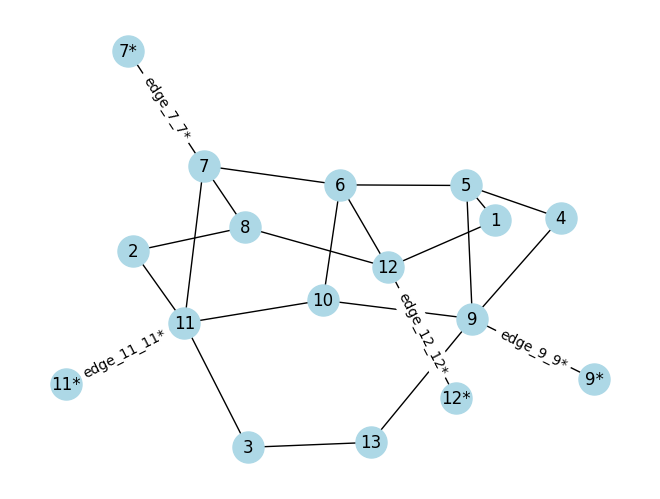

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

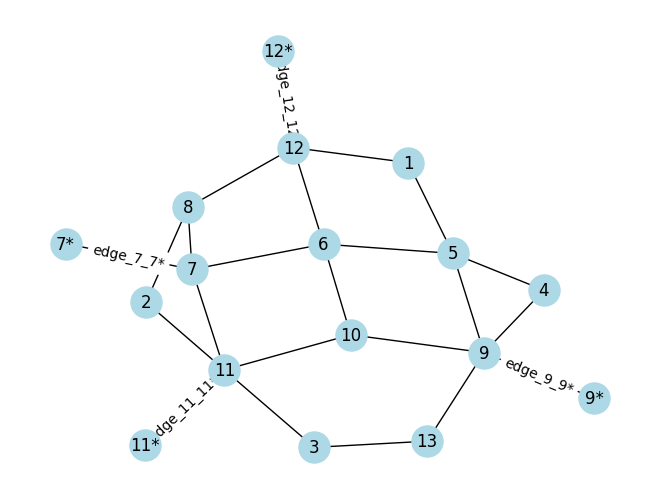

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

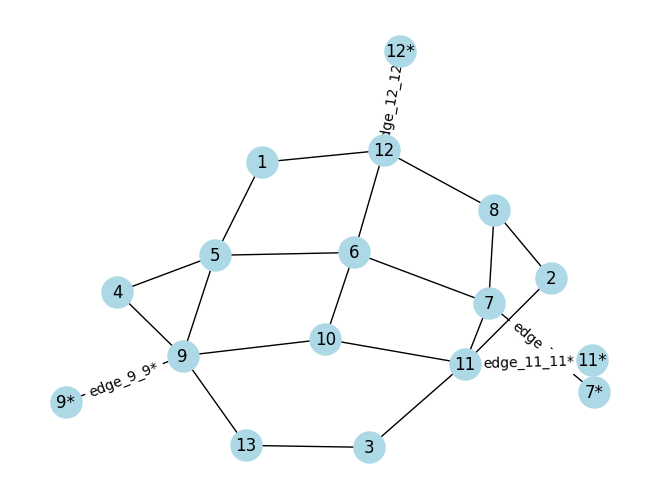

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

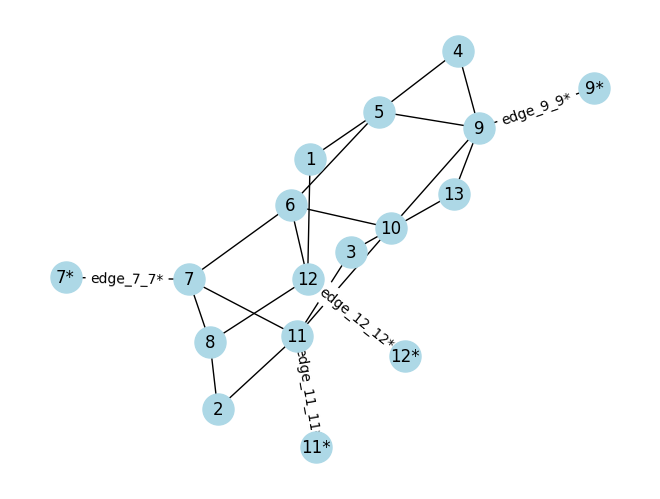

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

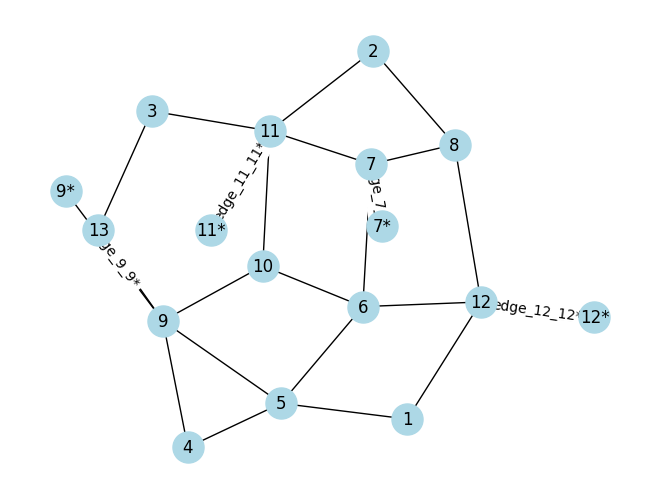

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

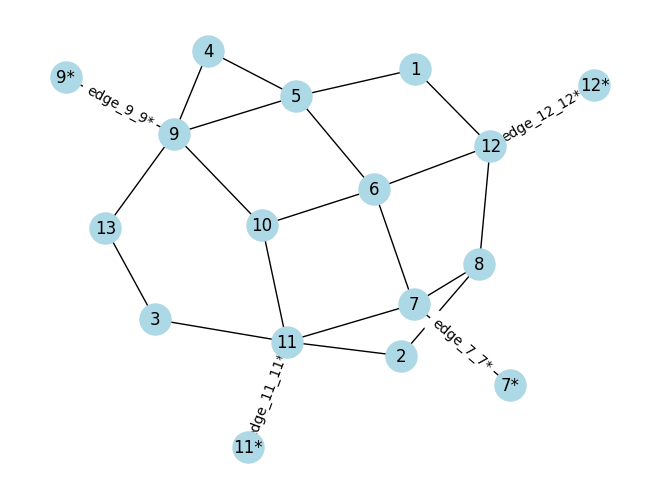

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

In [ ]:
# now we can run the model on a defined network and parameters

E=[15,11,15,15,7,6,5,7,5,5,5,6,5]
t=[10,10,10,10,10,10,10,10,10,10,10,10,10] # price for parking and maintenance
#Example usage:
nodes = range(1, 14)  # Example node list

# Parameters
lambda_1 = 1
lambda_2 = 2
lambda_3 = 3
mu = 4  # Service capacity per charger per unit time


 # list of node pairs

W = [(1, 2),(1,3), (4,2), (4,3)
]
predefined_paths_for_w = {
    (1, 2): [[1, 12, 8, 2]],
    (1, 3): [
        [1, 5, 6, 7, 11, 3],
        [1, 12, 6, 10, 11, 3],
        [1, 12, 6, 7, 11, 3],
        [1, 5, 9, 13, 3],
        [1, 5, 6, 10, 11, 3]
    ],
    (4, 2): [
        [4, 5, 6, 7, 8, 2],
        [4, 9, 10, 11, 2]
    ],
    (4, 3): [
        [4, 5, 6, 7, 11, 3],
        [4, 9, 13, 3]
    ]
}

# Initialize lists to store results
x_values_results = []
objective_values = []
y_values_results = []
q_values_results = []
#non chargings
population=100
# Proportion of vehicles who want to charge
charge_rate= 0.15

edges_with_distances = [
(1, 5, 7, 80.0),
(1, 12, 9, 120.0),
(12, 6, 7, 20.0),
(12, 8, 14, 100.0),
(5, 6, 3, 115.0),
(5, 9, 9, 51.0),
(6, 7, 5, 108.0),
(6, 10, 13, 28.0),
(7, 8, 5, 48.0),
(7, 11, 9, 59.0),
(8, 2, 9, 148.0),
(9, 10, 10, 52.0),
(9, 13, 9, 113.0),
(10, 11, 6, 79.0),
(13, 3, 3, 113.0),
(4, 5, 9, 86.0),
(4, 9, 12, 114.0),
(11, 3, 8, 87.0),
(11, 2, 9, 52.0)
]

B_values=[]
for B in np.arange(2, 11):

   # Extract required data
  data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
  W_named = data['W_named']
  expanded_paths_with_one_star = data['expanded_paths_with_one_star']
  path_links = data['path_links']
  gamma = data['gamma']
  e = data['e']
  d_l = data['d_l']
  k_l = data['k_l']
  gamma_0_l = data['gamma_0_l']
  T= data['T']

    # Run optimization
  x_values_adjusted = run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T)

      # Run the second optimization with fixed x values and store results
  objective_value, y_values, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted)

      # Store the results
  x_values_results.append(x_values_adjusted)
  objective_values.append(objective_value)
  y_values_results.append(y_values)
  q_values_results.append(q_values)
  B_values.append(B)

  print(f'B: {B}, Objective: {objective_value}')


# #####################################################
#sensitivity analysis on Lambda_2:
# Lambda_2_values=[0.5, 1, 2,4]
# for lambda_2 in Lambda_2_values:
#   B=20
#    # Extract required data
#   data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
#   W_named = data['W_named']
#   expanded_paths_with_one_star = data['expanded_paths_with_one_star']
#   path_links = data['path_links']
#   gamma = data['gamma']
#   e = data['e']
#   d_l = data['d_l']
#   k_l = data['k_l']
#   gamma_0_l = data['gamma_0_l']
#   T= data['T']

#     # Run optimization
#   x_values_adjusted = run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T)

#       # Run the second optimization with fixed x values and store results
#   objective_value, y_values, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted)

#       # Store the results
#   x_values_results.append(x_values_adjusted)
#   objective_values.append(objective_value)
#   y_values_results.append(y_values)
#   q_values_results.append(q_values)

#   print(f'Lambda_3: {lambda_2}, Objective: {objective_value}')



In [ ]:
objective_values

[6926.7561580692845,
 6383.319145793768,
 6255.940144850709,
 6181.022410571792,
 6140.661043520966,
 6121.0243601707525,
 6121.0243601707525,
 6121.0243601707525,
 6121.0243601707525]

Expanded Paths with One Star:
w_1:
  path_0: [1, 12, '12*', 12, 8, 2]
w_2:
  path_1: [1, 5, 6, 7, '7*', 7, 11, 3]
  path_2: [1, 5, 6, 7, 11, '11*', 11, 3]
  path_3: [1, 12, '12*', 12, 6, 10, 11, 3]
  path_4: [1, 12, 6, 10, 11, '11*', 11, 3]
  path_5: [1, 12, '12*', 12, 6, 7, 11, 3]
  path_6: [1, 12, 6, 7, '7*', 7, 11, 3]
  path_7: [1, 12, 6, 7, 11, '11*', 11, 3]
  path_8: [1, 5, 9, '9*', 9, 13, 3]
  path_9: [1, 5, 6, 10, 11, '11*', 11, 3]
w_3:
  path_10: [4, 5, 6, 7, '7*', 7, 8, 2]
  path_11: [4, 9, '9*', 9, 10, 11, 2]
  path_12: [4, 9, 10, 11, '11*', 11, 2]
w_4:
  path_13: [4, 5, 6, 7, '7*', 7, 11, 3]
  path_14: [4, 5, 6, 7, 11, '11*', 11, 3]
  path_15: [4, 9, '9*', 9, 13, 3]

Links for Each Named Path:
w_1:
  path_0: ['edge_1_12', 'edge_12_12*', 'edge_12*_12', 'edge_12_8', 'edge_8_2']
w_2:
  path_1: ['edge_1_5', 'edge_5_6', 'edge_6_7', 'edge_7_7*', 'edge_7*_7', 'edge_7_11', 'edge_11_3']
  path_2: ['edge_1_5', 'edge_5_6', 'edge_6_7', 'edge_7_11', 'edge_11_11*', 'edge_11*_11', 'edge_11

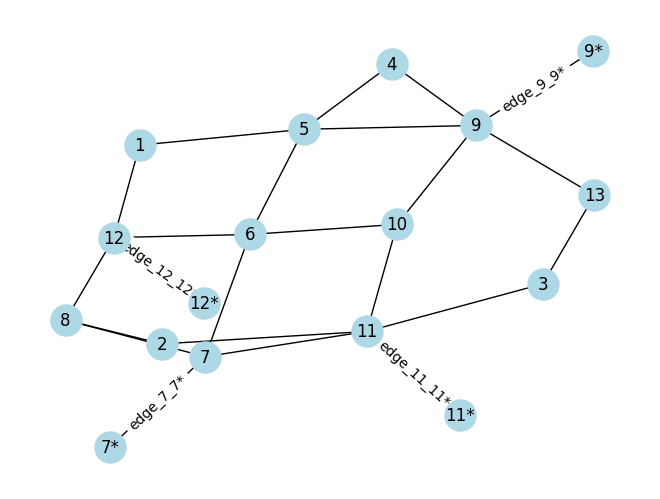

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

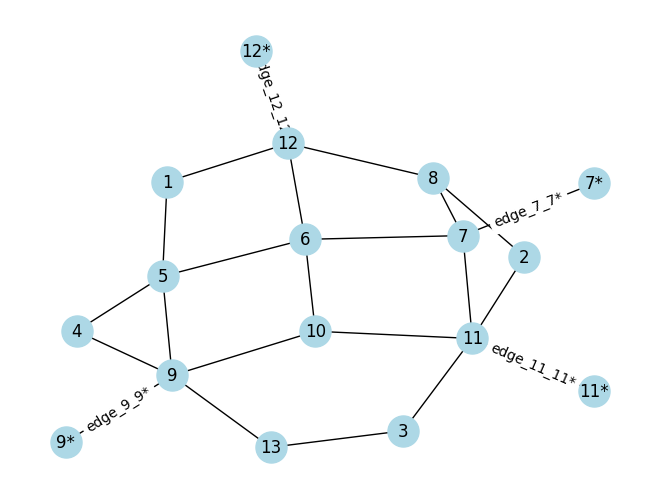

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

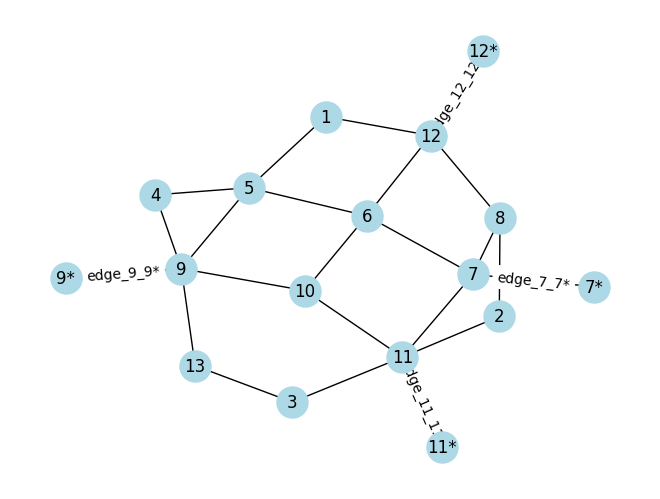

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

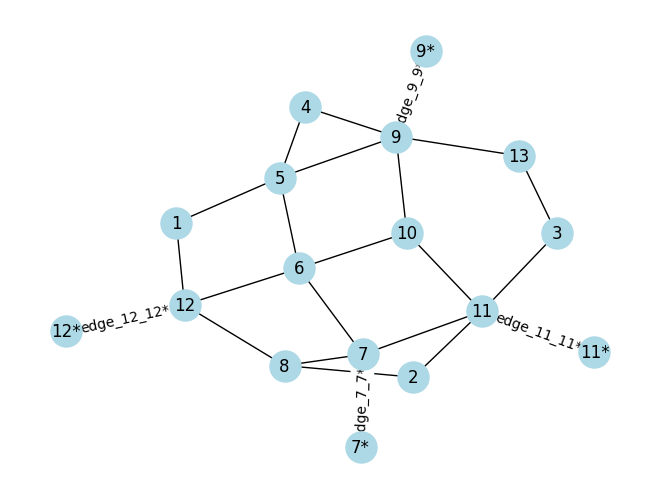

Ipopt 3.13.2: max_iter=100000

==> Warning: Treating 0 binary and 4 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a c

In [ ]:
# now we can run the model on a defined network and parameters

E=[15,11,15,15,7,6,5,7,5,5,5,6,5]
t=[10,10,10,10,10,10,10,10,10,10,10,10,10] # price for parking and maintenance
#Example usage:
nodes = range(1, 14)  # Example node list

# Parameters
lambda_1 = 1
lambda_2 = 2
lambda_3 = 3
mu = 4  # Service capacity per charger per unit time


 # list of node pairs

W = [(1, 2),(1,3), (4,2), (4,3)
]
predefined_paths_for_w = {
    (1, 2): [[1, 12, 8, 2]],
    (1, 3): [
        [1, 5, 6, 7, 11, 3],
        [1, 12, 6, 10, 11, 3],
        [1, 12, 6, 7, 11, 3],
        [1, 5, 9, 13, 3],
        [1, 5, 6, 10, 11, 3]
    ],
    (4, 2): [
        [4, 5, 6, 7, 8, 2],
        [4, 9, 10, 11, 2]
    ],
    (4, 3): [
        [4, 5, 6, 7, 11, 3],
        [4, 9, 13, 3]
    ]
}

# Initialize lists to store results
x_values_results = []
objective_values = []
y_values_results = []
q_values_results = []
#non chargings
population=100
# Proportion of vehicles who want to charge
charge_rate= 0.15

edges_with_distances = [
(1, 5, 7, 80.0),
(1, 12, 9, 120.0),
(12, 6, 7, 20.0),
(12, 8, 14, 100.0),
(5, 6, 3, 115.0),
(5, 9, 9, 51.0),
(6, 7, 5, 108.0),
(6, 10, 13, 28.0),
(7, 8, 5, 48.0),
(7, 11, 9, 59.0),
(8, 2, 9, 148.0),
(9, 10, 10, 52.0),
(9, 13, 9, 113.0),
(10, 11, 6, 79.0),
(13, 3, 3, 113.0),
(4, 5, 9, 86.0),
(4, 9, 12, 114.0),
(11, 3, 8, 87.0),
(11, 2, 9, 52.0)
]

# B_values=[]
# for B in np.arange(2, 11):

#    # Extract required data
#   data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
#   W_named = data['W_named']
#   expanded_paths_with_one_star = data['expanded_paths_with_one_star']
#   path_links = data['path_links']
#   gamma = data['gamma']
#   e = data['e']
#   d_l = data['d_l']
#   k_l = data['k_l']
#   gamma_0_l = data['gamma_0_l']
#   T= data['T']

#     # Run optimization
#   x_values_adjusted = run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T)

#       # Run the second optimization with fixed x values and store results
#   objective_value, y_values, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted)

#       # Store the results
#   x_values_results.append(x_values_adjusted)
#   objective_values.append(objective_value)
#   y_values_results.append(y_values)
#   q_values_results.append(q_values)
#   B_values.append(B)

#   print(f'B: {B}, Objective: {objective_value}')


# #####################################################
#sensitivity analysis on Lambda_2:
Lambda_2_values=[0.5, 1, 2,4]
for lambda_2 in Lambda_2_values:
  B=20
   # Extract required data
  data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
  W_named = data['W_named']
  expanded_paths_with_one_star = data['expanded_paths_with_one_star']
  path_links = data['path_links']
  gamma = data['gamma']
  e = data['e']
  d_l = data['d_l']
  k_l = data['k_l']
  gamma_0_l = data['gamma_0_l']
  T= data['T']

    # Run optimization
  x_values_adjusted = run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T)

      # Run the second optimization with fixed x values and store results
  objective_value, y_values, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted)

      # Store the results
  x_values_results.append(x_values_adjusted)
  objective_values.append(objective_value)
  y_values_results.append(y_values)
  q_values_results.append(q_values)

  print(f'Lambda_2: {lambda_2}, Objective: {objective_value}')



## **Now lets fix the placement and optimise the price- optimising only one parameter**

In [ ]:

def run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted):
    def s(path_name, expanded_paths_with_one_star):
        for key, path_dict in expanded_paths_with_one_star.items():
            if path_name in path_dict:
                path = path_dict[path_name]
                for node in path:
                    if '*' in str(node):
                        return node
        return None

    s_p_set = {s(p_prime, expanded_paths_with_one_star) for omega in W_named for p_prime in expanded_paths_with_one_star[omega].keys()}
    model = ConcreteModel()

    # Define the model variables
    model.q = Var(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), within=NonNegativeReals, initialize=0)
    model.y = Var((s_p for s_p in s_p_set if s_p is not None), within=NonNegativeReals, initialize=0)

    # Define the s(p) function


    # Define the objective function
    def objective_function(model):
        objective_value = 0.0
        for omega in W_named:
            for path_name, path in expanded_paths_with_one_star[omega].items():
                links = path_links[omega][path_name]

                # First term in the objective
                term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in links
                )
                # Second term in the objective
                s_p = s(path_name, expanded_paths_with_one_star)
                if s_p is not None:
                    term2 = lambda_2 * (
                        # First part: Sum for omega' != omega (different O-D pairs)
                        sum(
                            (gamma[omega_prime] * model.q[(omega_prime, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p and omega_prime != omega
                        )
                        # Second part: Sum for omega = omega (same O-D pair) with the +1 term
                        + sum(
                            ((gamma[omega] - 1) * model.q[(omega, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for p_prime, p_path in expanded_paths_with_one_star[omega].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p
                        )
                        + 1  # The "+1" term that was missing earlier
                    )
                else:
                    term2 = 0
                # Third term in the objective
                term3 = lambda_3 * model.y[s(path_name, expanded_paths_with_one_star)]

                # Adding terms to the objective function
                objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1 + term2+ term3)

        return objective_value

    model.objective = Objective(rule=objective_function, sense=minimize)

    #if the
    def conditional_q_constraint(model, omega, path_name):
        s_p = s(path_name, expanded_paths_with_one_star)  # Get the s_p value for the current path

        if s_p is not None and x_values_adjusted[s_p] == 0:
            return model.q[(omega, path_name)] == 0
        else:
            return Constraint.Skip  # Skip the constraint if x_values_adjusted[s_p] is not zero

    model.conditional_q_constraints = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=conditional_q_constraint)


    # Constraint: sum of q variables for each omega must equal 1
    def q_constraint_rule(model, omega):
        return sum(model.q[(omega, path_name)] for path_name in expanded_paths_with_one_star[omega]) == 1

    model.q_constraint = Constraint(W_named, rule=q_constraint_rule)






    # Extract unique s(p) values
    unique_s_p_values = set(x_values_adjusted.keys())

    # Define the cost constraint function
    def cost_constraint(model, s_p):
        lhs = sum(gamma[omega_prime] * model.q[(omega_prime, p_prime)] * e[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p) + (1.2*T[s_p]*x_values_adjusted[s_p])

        rhs = sum((gamma[omega_prime] * model.q[(omega_prime, p_prime)]) * model.y[s_p]
                  for omega_prime in W_named
                  for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                  if s(p_prime, expanded_paths_with_one_star) == s_p)

        return lhs <= rhs

    # Apply the cost constraint to the model
    model.cost_constraints = Constraint(unique_s_p_values, rule=cost_constraint)

    # Ensure q values are non-negative
    model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)


    # model.path_comparison_constraint = Constraint(((omega, m, h) for omega in W_named for m in expanded_paths_with_one_star[omega] for h in expanded_paths_with_one_star[omega] if m != h), rule=path_comparison_constraint)
    def path_comparison_constraint(model, omega, m, h):
        # Define terms for the left-hand side (h path)
        lhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][h]
                )

        lhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for h_prime, h_path in expanded_paths_with_one_star[omega].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star)
        ) + 1

        lhs_term3 = model.y[s(h, expanded_paths_with_one_star)]

        lhs = (lambda_1 * lhs_term1 + lambda_2 * lhs_term2 + lambda_3 * lhs_term3)

        # Define terms for the right-hand side (m path)
        rhs_term1 = sum(
            d_l[l] * k_l[l] * (sum(gamma[omega_prime] * model.q[(omega_prime, m_prime)]
                                   for omega_prime in W_named
                                   for m_prime, m_path in expanded_paths_with_one_star[omega_prime].items()
                                   if l in path_links[omega_prime][m_prime]) + gamma_0_l[l])
            for l in path_links[omega][m]
        )

        rhs_term2 = sum(
            gamma[omega_prime] * model.q[(omega_prime, m_prime)] /
            (mu * x_values_adjusted[s(m, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for m_prime, m_path in expanded_paths_with_one_star[omega_prime].items()
            if s(m_prime, expanded_paths_with_one_star) == s(m, expanded_paths_with_one_star)
        )

        rhs_term3 = model.y[s(m, expanded_paths_with_one_star)]

        rhs = (lambda_1 * rhs_term1 + lambda_2 * rhs_term2 + lambda_3 * rhs_term3)

        # Constraint: lhs >= rhs
        return model.q[(omega, m)] * lhs >= model.q[(omega, m)] * rhs

    model.path_comparison_constraint = Constraint(
        ((omega, m, h) for omega in W_named
         for m in expanded_paths_with_one_star[omega]
         for h in expanded_paths_with_one_star[omega]
         if m != h),
        rule=path_comparison_constraint
    )

    # Solve the model
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = 100000
    results = solver.solve(model, tee=True)

    # Output the results
    print(f"Status: {results.solver.status}")
    for v in model.component_objects(Var, active=True):
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"{str(v)}[{index}] = {varobject[index].value}")
    print(x_values_adjusted)

    print(f"Objective value: {model.objective()}")
    y_values = {index: model.y[index].value for index in model.y}
    q_values = {(omega, path_name): model.q[(omega, path_name)].value for omega in W_named for path_name in expanded_paths_with_one_star[omega]}
    objective_value = model.objective()
    return objective_value, y_values, q_values



Expanded Paths with One Star:
w_1:
  path_0: [1, '1*', 1, 12, 8, 2]
  path_1: [1, 12, '12*', 12, 8, 2]
  path_2: [1, 12, 8, '8*', 8, 2]
  path_3: [1, 12, 8, 2, '2*', 2]
w_2:
  path_4: [1, '1*', 1, 5, 6, 7, 11, 3]
  path_5: [1, 5, '5*', 5, 6, 7, 11, 3]
  path_6: [1, 5, 6, '6*', 6, 7, 11, 3]
  path_7: [1, 5, 6, 7, '7*', 7, 11, 3]
  path_8: [1, 5, 6, 7, 11, '11*', 11, 3]
  path_9: [1, 5, 6, 7, 11, 3, '3*', 3]
  path_10: [1, '1*', 1, 12, 6, 10, 11, 3]
  path_11: [1, 12, '12*', 12, 6, 10, 11, 3]
  path_12: [1, 12, 6, '6*', 6, 10, 11, 3]
  path_13: [1, 12, 6, 10, '10*', 10, 11, 3]
  path_14: [1, 12, 6, 10, 11, '11*', 11, 3]
  path_15: [1, 12, 6, 10, 11, 3, '3*', 3]
  path_16: [1, '1*', 1, 12, 6, 7, 11, 3]
  path_17: [1, 12, '12*', 12, 6, 7, 11, 3]
  path_18: [1, 12, 6, '6*', 6, 7, 11, 3]
  path_19: [1, 12, 6, 7, '7*', 7, 11, 3]
  path_20: [1, 12, 6, 7, 11, '11*', 11, 3]
  path_21: [1, 12, 6, 7, 11, 3, '3*', 3]
  path_22: [1, '1*', 1, 5, 9, 13, 3]
  path_23: [1, 5, '5*', 5, 9, 13, 3]
  path_2

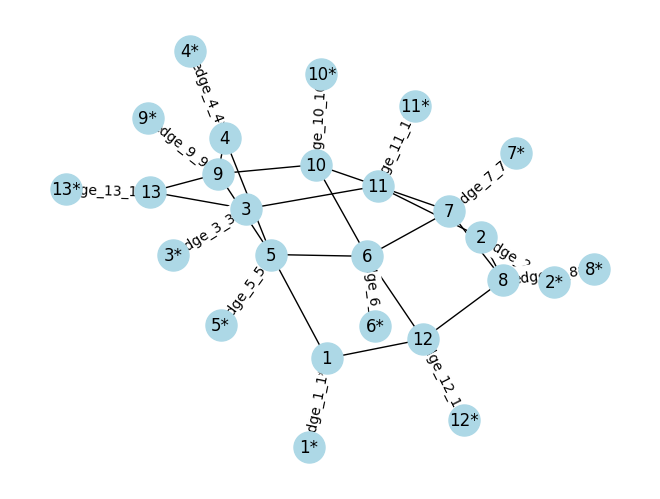

Ipopt 3.13.2: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computat

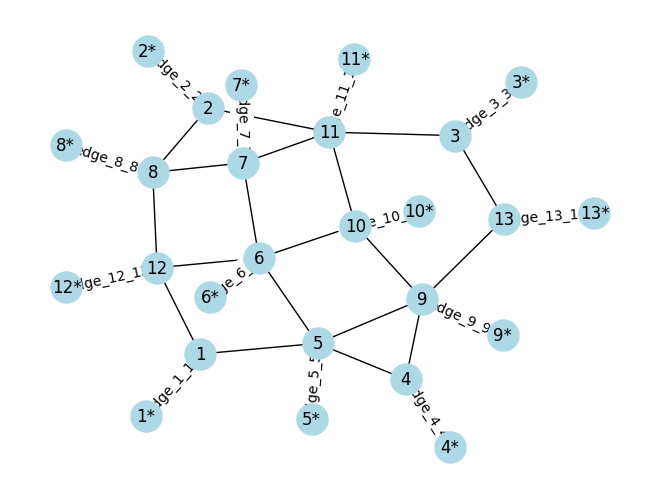

Ipopt 3.13.2: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computat

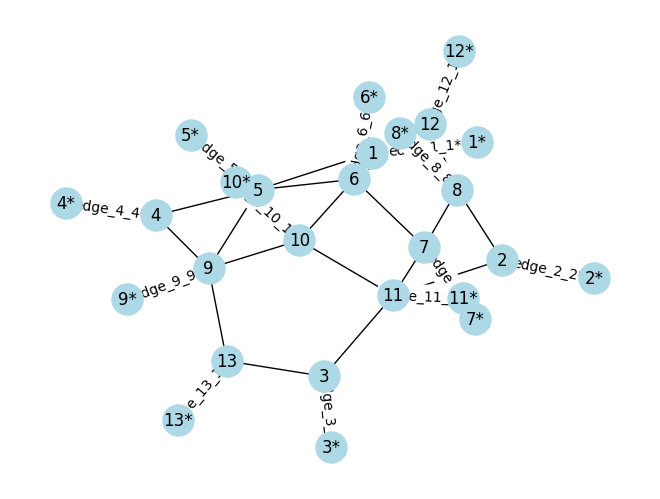

Ipopt 3.13.2: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computat

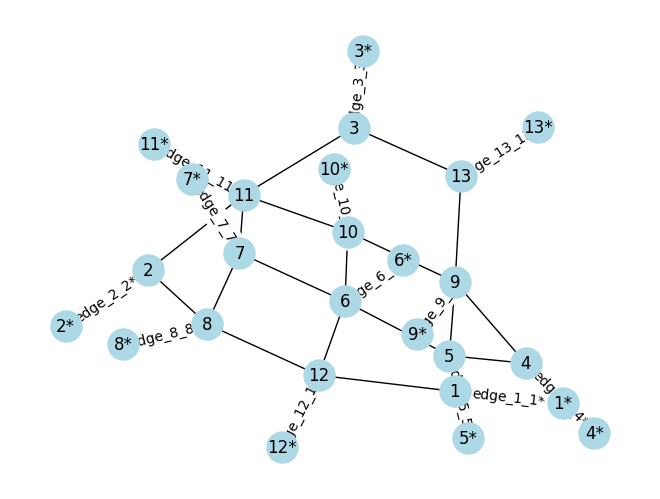

Ipopt 3.13.2: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computat

In [ ]:


E=[15,11,15,15,7,6,5,7,5,5,5,6,5]
t=[10,10,10,10,10,10,10,10,10,10,10,10,10] # price for parking and maintenance

nodes = range(1, 14)

# Parameters
lambda_1 = 1
lambda_2 = 2
lambda_3 = 3
mu = 4  # Service capacity per charger per unit time

W = [(1, 2),(1,3), (4,2), (4,3)
]
predefined_paths_for_w = {
    (1, 2): [[1, 12, 8, 2]],
    (1, 3): [
        [1, 5, 6, 7, 11, 3],
        [1, 12, 6, 10, 11, 3],
        [1, 12, 6, 7, 11, 3],
        [1, 5, 9, 13, 3],
        [1, 5, 6, 10, 11, 3]
    ],
    (4, 2): [
        [4, 5, 6, 7, 8, 2],
        [4, 9, 10, 11, 2]
    ],
    (4, 3): [
        [4, 5, 6, 7, 11, 3],
        [4, 9, 13, 3]
    ]
}

# Initialize lists to store results
x_values_results_1 = []
objective_values_1 = []
y_values_results_1 = []
q_values_results_1 = []
population=100
charge_rate= 0.15

edges_with_distances = [
(1, 5, 7, 80.0),
(1, 12, 9, 120.0),
(12, 6, 7, 20.0),
(12, 8, 14, 100.0),
(5, 6, 3, 115.0),
(5, 9, 9, 51.0),
(6, 7, 5, 108.0),
(6, 10, 13, 28.0),
(7, 8, 5, 48.0),
(7, 11, 9, 59.0),
(8, 2, 9, 148.0),
(9, 10, 10, 52.0),
(9, 13, 9, 113.0),
(10, 11, 6, 79.0),
(13, 3, 3, 113.0),
(4, 5, 9, 86.0),
(4, 9, 12, 114.0),
(11, 3, 8, 87.0),
(11, 2, 9, 52.0)
]

for B in np.arange(13, 65, 13):
  x_values_adjusted= {
      '1*': B/13, '2*': B/13, '3*': B/13, '4*': B/13, '5*': B/13, '6*': B/13, '7*': B/13, '8*': B/13, '9*': B/13, '10*': B/13,
      '11*': B/13, '12*': B/13,
      '13*': B/13
      }

    # Extract required data
  data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
  W_named = data['W_named']
  expanded_paths_with_one_star = data['expanded_paths_with_one_star']
  path_links = data['path_links']
  gamma = data['gamma']
  e = data['e']
  d_l = data['d_l']
  k_l = data['k_l']
  gamma_0_l = data['gamma_0_l']
  T= data['T']

      # Run optimization
      # Run the second optimization with fixed x values and store results
  objective_value, y_values, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted)

      # Store the results
  #charge_rates.append(charge_rate)
  x_values_results_1.append(x_values_adjusted)
  objective_values_1.append(objective_value)
  y_values_results_1.append(y_values)
  q_values_results_1.append(q_values)

  print(f'B: {B}, Objective: {objective_value}')

In [ ]:
objective_values_1

[np.float64(7112.58606466567),
 np.float64(7642.888035139014),
 np.float64(7959.45359200553),
 np.float64(8288.366390657697)]

In [ ]:
#measuring how joint optimisation is better than one parameter optimisation
difference=[]
for i in range(len(objective_values_1)):
  difference.append((-(objective_values[i]-objective_values_1[i])/objective_values[i])*100)

print(difference)

NameError: name 'objective_values' is not defined

### **Now fixing the price and Optimising the placement- one parameter optimisation**

In [ ]:


def run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, price):
    # Define the s(p) function
    def s(path_name, expanded_paths_with_one_star):
        for key, path_dict in expanded_paths_with_one_star.items():
            if path_name in path_dict:
                path = path_dict[path_name]
                for node in path:
                    if '*' in str(node):
                        return node
        return None

    # Collect all unique s(p) values
    s_p_set = {s(p_prime, expanded_paths_with_one_star) for omega in W_named for p_prime in expanded_paths_with_one_star[omega].keys()}

    # Define the model
    model = ConcreteModel()

    # Define the model variables
    model.q = Var(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), within=NonNegativeReals, initialize=0)
    model.x = Var((s_p for s_p in s_p_set if s_p is not None), within=NonNegativeIntegers, initialize=0)


    # Define the objective function
    def objective_function(model):
        objective_value = 0.0
        for omega in W_named:
            for path_name, path in expanded_paths_with_one_star[omega].items():
                links = path_links[omega][path_name]

                term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in links
                )

                # Calculate term2 for the unique s(p) value
                s_p = s(path_name, expanded_paths_with_one_star)
                if s_p is not None:
                    term2 = lambda_2 * (
                        # First part: Sum for omega' != omega (different O-D pairs)
                        sum(
                            (gamma[omega_prime] * model.q[(omega_prime, p_prime)] / (mu * model.x[s_p] + 0.1))
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p and omega_prime != omega
                        )
                        # Second part: Sum for omega = omega (same O-D pair) with the +1 term
                        + sum(
                            ((gamma[omega] - 1) * model.q[(omega, p_prime)] / (mu * model.x[s_p] + 0.1))
                            for p_prime, p_path in expanded_paths_with_one_star[omega].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p
                        )
                        + 1  # The "+1" term that was missing earlier
                    )
                else:
                    term2 = 0

                term3 = lambda_3 * price

                objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1 + term2+ term3)

        return objective_value

    model.objective = Objective(rule=objective_function, sense=minimize)

    # Constraints
    def budget_constraint(model):
        return sum(model.x[s_p] for s_p in s_p_set if s_p is not None) <= B

    model.budget_constraint = Constraint(rule=budget_constraint)

    def q_constraint_rule(model, omega):
        return sum(model.q[(omega, path_name)] for path_name in expanded_paths_with_one_star[omega]) == 1

    model.q_constraint = Constraint(W_named, rule=q_constraint_rule)

    # Extract unique s(p) values
    unique_s_p_values = set()
    for omega in W_named:
        for path_name in expanded_paths_with_one_star[omega]:
            s_p = s(path_name, expanded_paths_with_one_star)
            if s_p is not None:
                unique_s_p_values.add(s_p)


    model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)


    # model.path_comparison_constraint = Constraint(((omega, m, h) for omega in W_named for m in expanded_paths_with_one_star[omega] for h in expanded_paths_with_one_star[omega] if m != h), rule=path_comparison_constraint)
    def path_comparison_constraint(model, omega, m, h):
        # Define terms for the left-hand side (h path)
        lhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][h]
                )

        lhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for h_prime, h_path in expanded_paths_with_one_star[omega].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star)
        ) + 1
        lhs_term3 = price

        lhs =  (lambda_1 * lhs_term1 + lambda_2 * lhs_term2 + lambda_3 * lhs_term3)

        # Define terms for the right-hand side (m path)
        rhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][m]
                )
        rhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * model.x[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, m_prime)] /
            (mu * model.x[s(m_prime, expanded_paths_with_one_star)] + 0.01)
            for m_prime, m_path in expanded_paths_with_one_star[omega].items()
            if s(m_prime, expanded_paths_with_one_star) == s(m, expanded_paths_with_one_star)
        ) + 1

        rhs_term3 = price

        rhs =  (lambda_1 * rhs_term1 + lambda_2 * rhs_term2 + lambda_3 * rhs_term3)

        # Constraint: lhs >= rhs
        return model.q[(omega, m)] * lhs >= model.q[(omega, m)] *rhs

    model.path_comparison_constraint = Constraint(
        ((omega, m, h) for omega in W_named
         for m in expanded_paths_with_one_star[omega]
         for h in expanded_paths_with_one_star[omega]
         if m != h),
        rule=path_comparison_constraint
    )
    # Solve the model
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = 100000
    results = solver.solve(model, tee=True)
        # Output the results
    print(f"Status: {results.solver.status}")
    print(f"Objective value: {model.objective()}")
    for v in model.component_objects(Var, active=True):
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"{str(v)}[{index}] = {varobject[index].value}")

    # Rounding the x values
    x_values = {}

    # Iterate over the variables in the model and store the values of variable x in the dictionary
    for v in model.component_objects(Var, active=True):
        if str(v) == 'x':  # Check if the variable is 'x'
            varobject = getattr(model, str(v))
            for index in varobject:
                x_values[index] = varobject[index].value
    #Adjust X values
    def adjust_x_values_dict(x_values):
    # Step 1: Sort the dictionary items by the fractional part of their values in descending order
      sorted_items = sorted(x_values.items(), key=lambda item: item[1] - int(item[1]), reverse=True)

    # Step 2: Floor all the values and calculate the initial sum
      floored_values = {key: int(value) for key, value in sorted_items}
      initial_sum = sum(floored_values.values())
      Z= sum(x_values.values())

    # Step 3: Calculate the difference between B and the initial sum
      difference = Z - initial_sum

    # Step 4: Increment the values with the highest fractional parts
      for i in range(int(round(difference))):
        key = sorted_items[i][0]
        floored_values[key] += 1

      return floored_values
    x_values_adjusted = adjust_x_values_dict(x_values)

    # Deleting components
    if hasattr(model, 'x'):
        model.del_component(model.x)
    if hasattr(model, 'q'):
        model.del_component(model.q)
    if hasattr(model, 'y'):
        model.del_component(model.y)

    return x_values_adjusted


In [ ]:
#now that we have x in integer, we need to get the strategies
def run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted, price):
    def s(path_name, expanded_paths_with_one_star):
        for key, path_dict in expanded_paths_with_one_star.items():
            if path_name in path_dict:
                path = path_dict[path_name]
                for node in path:
                    if '*' in str(node):
                        return node
        return None

    s_p_set = {s(p_prime, expanded_paths_with_one_star) for omega in W_named for p_prime in expanded_paths_with_one_star[omega].keys()}
    model = ConcreteModel()

    # Define the model variables
    model.q = Var(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), within=NonNegativeReals, initialize=0)


    # Define the objective function
    def objective_function(model):
        objective_value = 0.0
        for omega in W_named:
            for path_name, path in expanded_paths_with_one_star[omega].items():
                links = path_links[omega][path_name]

                # First term in the objective
                term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in links
                )
                # Second term in the objective
                s_p = s(path_name, expanded_paths_with_one_star)
                if s_p is not None:
                    term2 = lambda_2 * (
                        # First part: Sum for omega' != omega (different O-D pairs)
                        sum(
                            (gamma[omega_prime] * model.q[(omega_prime, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p and omega_prime != omega
                        )
                        # Second part: Sum for omega = omega (same O-D pair) with the +1 term
                        + sum(
                            ((gamma[omega] - 1) * model.q[(omega, p_prime)] / (mu * x_values_adjusted[s_p] + 0.1))
                            for p_prime, p_path in expanded_paths_with_one_star[omega].items()
                            if s(p_prime, expanded_paths_with_one_star) == s_p
                        )
                        + 1  # The "+1" term that was missing earlier
                    )
                else:
                    term2 = 0


                # Third term in the objective
                term3 = lambda_3 * price
                # Adding terms to the objective function
                objective_value += gamma[omega] * model.q[(omega, path_name)] * (term1 + term2+ term3)

        return objective_value

    model.objective = Objective(rule=objective_function, sense=minimize)

    #if the
    def conditional_q_constraint(model, omega, path_name):
        s_p = s(path_name, expanded_paths_with_one_star)  # Get the s_p value for the current path

        if s_p is not None and x_values_adjusted[s_p] == 0:
            return model.q[(omega, path_name)] == 0
        else:
            return Constraint.Skip  # Skip the constraint if x_values_adjusted[s_p] is not zero

    model.conditional_q_constraints = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=conditional_q_constraint)

    # Constraint: sum of q variables for each omega must equal 1
    def q_constraint_rule(model, omega):
        return sum(model.q[(omega, path_name)] for path_name in expanded_paths_with_one_star[omega]) == 1

    model.q_constraint = Constraint(W_named, rule=q_constraint_rule)


    # Extract unique s(p) values
    unique_s_p_values = set(x_values_adjusted.keys())

    model.q_non_negative = Constraint(((omega, path_name) for omega in W_named for path_name in expanded_paths_with_one_star[omega]), rule=lambda model, omega, path_name: model.q[(omega, path_name)] >= 0)


    def path_comparison_constraint(model, omega, m, h):
        # Define terms for the left-hand side (h path)
        lhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][h]
                )

        lhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for h_prime, h_path in expanded_paths_with_one_star[omega].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star)
        ) + 1

        lhs_term3 = price

        lhs = (lambda_1 * lhs_term1 + lambda_2 * lhs_term2 + lambda_3 * lhs_term3)

        # Define terms for the right-hand side (m path)
        rhs_term1 = sum(
                    lambda_1 * d_l[l] * k_l[l] * (
                        gamma_0_l[l] +  # Include the base gamma_0_l
                        sum(
                            gamma[omega_prime] * model.q[(omega_prime, p_prime)]  # Influence from other O-D pairs
                            for omega_prime in W_named
                            for p_prime, p_path in expanded_paths_with_one_star[omega_prime].items()
                            if l in path_links[omega_prime][p_prime]
                        ) +  # Include the gamma for current O-D pair
                        sum(
                            (gamma[omega] - 1) * model.q[(omega, p_prime)]  # Influence of the current O-D pair
                            for p_prime in expanded_paths_with_one_star[omega]
                            if l in path_links[omega][p_prime]
                        ) + 1  # Adding the constant +1
                    )
                    for l in path_links[omega][m]
                )
        rhs_term2 = sum(
            # First part: For omega_prime != omega (different O-D pair)
            gamma[omega_prime] * model.q[(omega_prime, h_prime)] /
            (mu * x_values_adjusted[s(h_prime, expanded_paths_with_one_star)] + 0.01)
            for omega_prime in W_named
            for h_prime, h_path in expanded_paths_with_one_star[omega_prime].items()
            if s(h_prime, expanded_paths_with_one_star) == s(h, expanded_paths_with_one_star) and omega_prime != omega
        ) + sum(
            # Second part: For omega_prime == omega (same O-D pair) with the +1 term
            (gamma[omega] - 1) * model.q[(omega, m_prime)] /
            (mu * x_values_adjusted[s(m_prime, expanded_paths_with_one_star)] + 0.01)
            for m_prime, m_path in expanded_paths_with_one_star[omega].items()
            if s(m_prime, expanded_paths_with_one_star) == s(m, expanded_paths_with_one_star)
        ) + 1


        rhs_term3 = price
        rhs =  (lambda_1 * rhs_term1 + lambda_2 * rhs_term2 + lambda_3 * rhs_term3)

        # Constraint: lhs >= rhs
        return model.q[(omega, m)] * lhs >= model.q[(omega, m)] * rhs

    model.path_comparison_constraint = Constraint(
        ((omega, m, h) for omega in W_named
         for m in expanded_paths_with_one_star[omega]
         for h in expanded_paths_with_one_star[omega]
         if m != h),
        rule=path_comparison_constraint
    )

    # Solve the model
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = 100000
    results = solver.solve(model, tee=True)

    # Output the results
    print(f"Status: {results.solver.status}")
    for v in model.component_objects(Var, active=True):
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"{str(v)}[{index}] = {varobject[index].value}")
    print(x_values_adjusted)

    print(f"Objective value: {model.objective()}")
    #y_values = {index: model.y[index].value for index in model.y}
    q_values = {(omega, path_name): model.q[(omega, path_name)].value for omega in W_named for path_name in expanded_paths_with_one_star[omega]}
    objective_value = model.objective()
    return objective_value, q_values





Expanded Paths with One Star:
w_1:
  path_0: [1, '1*', 1, 12, 8, 2]
  path_1: [1, 12, '12*', 12, 8, 2]
  path_2: [1, 12, 8, '8*', 8, 2]
  path_3: [1, 12, 8, 2, '2*', 2]
w_2:
  path_4: [1, '1*', 1, 5, 6, 7, 11, 3]
  path_5: [1, 5, '5*', 5, 6, 7, 11, 3]
  path_6: [1, 5, 6, '6*', 6, 7, 11, 3]
  path_7: [1, 5, 6, 7, '7*', 7, 11, 3]
  path_8: [1, 5, 6, 7, 11, '11*', 11, 3]
  path_9: [1, 5, 6, 7, 11, 3, '3*', 3]
  path_10: [1, '1*', 1, 12, 6, 10, 11, 3]
  path_11: [1, 12, '12*', 12, 6, 10, 11, 3]
  path_12: [1, 12, 6, '6*', 6, 10, 11, 3]
  path_13: [1, 12, 6, 10, '10*', 10, 11, 3]
  path_14: [1, 12, 6, 10, 11, '11*', 11, 3]
  path_15: [1, 12, 6, 10, 11, 3, '3*', 3]
  path_16: [1, '1*', 1, 12, 6, 7, 11, 3]
  path_17: [1, 12, '12*', 12, 6, 7, 11, 3]
  path_18: [1, 12, 6, '6*', 6, 7, 11, 3]
  path_19: [1, 12, 6, 7, '7*', 7, 11, 3]
  path_20: [1, 12, 6, 7, 11, '11*', 11, 3]
  path_21: [1, 12, 6, 7, 11, 3, '3*', 3]
  path_22: [1, '1*', 1, 5, 9, 13, 3]
  path_23: [1, 5, '5*', 5, 9, 13, 3]
  path_2

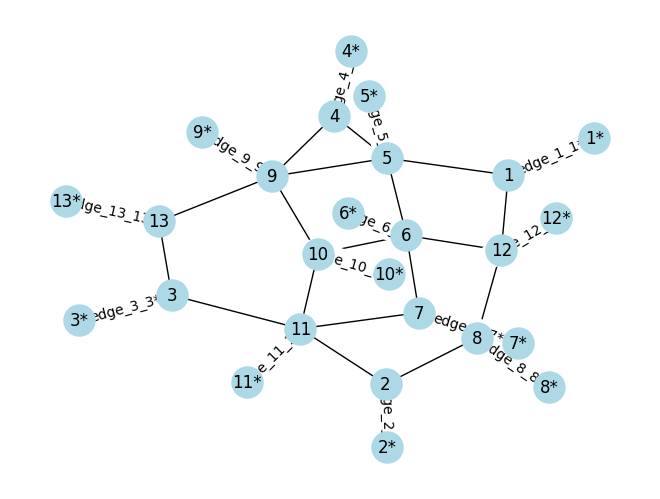

Streaming output truncated to the last 5000 lines.
3524r 8.4963014e+03 3.40e-07 1.91e+01  -3.8 2.94e-03   0.9 1.00e+00 3.12e-02h  6
3525r 8.4963024e+03 3.40e-07 1.41e+01  -3.8 8.54e-04   1.3 1.00e+00 1.25e-01h  4
3526r 8.4963034e+03 3.40e-07 1.75e+01  -3.8 3.41e-03   0.8 1.00e+00 3.12e-02h  6
3527r 8.4963045e+03 3.40e-07 1.22e+01  -3.8 9.78e-04   1.3 1.00e+00 1.25e-01h  4
3528r 8.4963444e+03 1.82e-06 2.35e+01  -3.8 3.92e-03   0.8 1.00e+00 1.00e+00h  1
3529r 8.4963582e+03 3.40e-07 1.61e+01  -3.8 1.10e-03   0.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3530r 8.4963665e+03 3.40e-07 6.07e+01  -3.8 3.15e-03   0.7 1.00e+00 2.50e-01h  3
3531r 8.4963767e+03 3.40e-07 1.58e+01  -3.8 1.70e-03   1.2 1.00e+00 5.00e-01h  2
3532r 8.4963810e+03 3.40e-07 8.76e+01  -3.8 9.53e-03   0.7 7.86e-01 3.55e-02h  5
3533r 8.4963860e+03 3.40e-07 2.73e+01  -3.8 8.24e-04   2.0 1.00e+00 5.00e-01h  2
3534r 8.4963967e+03 3.40e-07 2.06e+01  -3.8 7.97e-04   1.5

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


Status: warning
q[('w_1', 'path_0')] = 0.0006234413954420933
q[('w_1', 'path_1')] = 0.0006234413954421055
q[('w_1', 'path_2')] = 0.9981296758136632
q[('w_1', 'path_3')] = 0.0006234413954420935
q[('w_2', 'path_4')] = 1.9919510086548803e-09
q[('w_2', 'path_5')] = 1.4918417027072007e-09
q[('w_2', 'path_6')] = 1.4918350319282565e-09
q[('w_2', 'path_7')] = 7.089708867266408e-14
q[('w_2', 'path_8')] = 1.9919898640380915e-09
q[('w_2', 'path_9')] = 1.4918416074977857e-09
q[('w_2', 'path_10')] = 1.8936161939863428e-10
q[('w_2', 'path_11')] = 0.0
q[('w_2', 'path_12')] = 0.0
q[('w_2', 'path_13')] = 1.8936325959363323e-10
q[('w_2', 'path_14')] = 1.893632595883621e-10
q[('w_2', 'path_15')] = 0.0
q[('w_2', 'path_16')] = 9.932976321422904e-11
q[('w_2', 'path_17')] = 0.0
q[('w_2', 'path_18')] = 0.0
q[('w_2', 'path_19')] = 0.0
q[('w_2', 'path_20')] = 9.933023612660412e-11
q[('w_2', 'path_21')] = 0.0
q[('w_2', 'path_22')] = 0.00019753910661368765
q[('w_2', 'path_23')] = 0.32691647659866613
q[('w_2', 'pa

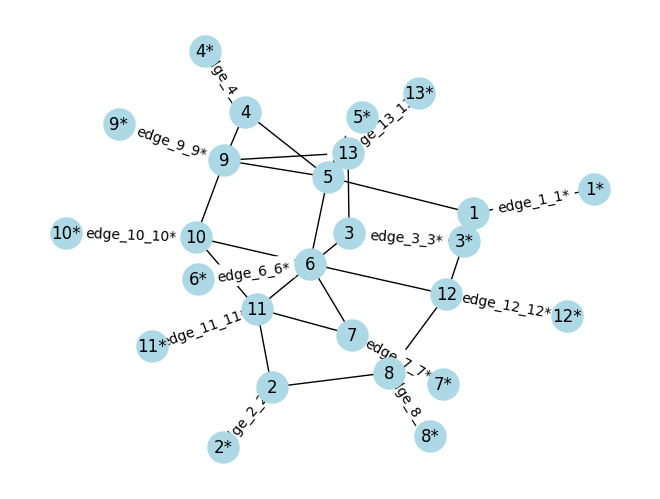

Streaming output truncated to the last 5000 lines.
3018  8.8983855e+03 1.28e-05 1.45e+07  -5.7 3.58e-01   0.2 1.76e-02 3.20e-04h  9
3019  8.8983855e+03 1.28e-05 1.48e+07  -5.7 3.43e+00  -0.3 1.58e-03 5.98e-05h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3020  8.8983855e+03 1.28e-05 1.84e+07  -5.7 3.91e-01   0.1 7.24e-02 1.62e-04h 10
3021  8.8983901e+03 3.54e-04 1.66e+07  -5.7 1.70e-01   0.5 2.08e-02 7.80e-02w  1
3022  8.8983902e+03 3.49e-04 1.41e+07  -5.7 6.17e-02   1.0 1.04e-01 1.18e-02w  1
3023  8.8983915e+03 3.33e-04 1.34e+07  -5.7 1.68e-01   0.5 9.07e-03 4.44e-02w  1
3024  8.8983855e+03 1.28e-05 1.86e+07  -5.7 5.17e-01   0.0 2.08e-02 6.09e-04h  7
3025  8.8983855e+03 1.28e-05 1.92e+07  -5.7 2.09e-01   0.4 5.56e-02 6.16e-04h  8
3026  8.8983856e+03 1.28e-05 1.95e+07  -5.7 5.00e-01  -0.0 5.51e-03 1.55e-04h 10
3027  8.8983856e+03 1.28e-05 2.14e+07  -5.7 2.29e-01   0.4 1.45e-01 6.20e-04h  8
3028  8.8983856e+03 1.28e-05 2.17e+07  -5.7 5.29e-01  -0.1

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


Status: warning
q[('w_1', 'path_0')] = 0.7994505459440931
q[('w_1', 'path_1')] = 0.0002497502474212681
q[('w_1', 'path_2')] = 0.20004995356106117
q[('w_1', 'path_3')] = 0.00024975024742127463
q[('w_2', 'path_4')] = 1.7041129422669725e-09
q[('w_2', 'path_5')] = 2.1492042866474443e-09
q[('w_2', 'path_6')] = 2.0198066901280035e-09
q[('w_2', 'path_7')] = 3.7783077936638136e-14
q[('w_2', 'path_8')] = 2.431064349960096e-09
q[('w_2', 'path_9')] = 1.704112817756985e-09
q[('w_2', 'path_10')] = 0.0
q[('w_2', 'path_11')] = 0.0
q[('w_2', 'path_12')] = 0.0
q[('w_2', 'path_13')] = 0.0
q[('w_2', 'path_14')] = 2.0231362603860996e-10
q[('w_2', 'path_15')] = 0.0
q[('w_2', 'path_16')] = 0.0
q[('w_2', 'path_17')] = 0.0
q[('w_2', 'path_18')] = 0.0
q[('w_2', 'path_19')] = 0.0
q[('w_2', 'path_20')] = 1.0528126550287088e-10
q[('w_2', 'path_21')] = 0.0
q[('w_2', 'path_22')] = 0.373119797386139
q[('w_2', 'path_23')] = 0.0001164804197543877
q[('w_2', 'path_24')] = 0.00011656352959475239
q[('w_2', 'path_25')] = 0

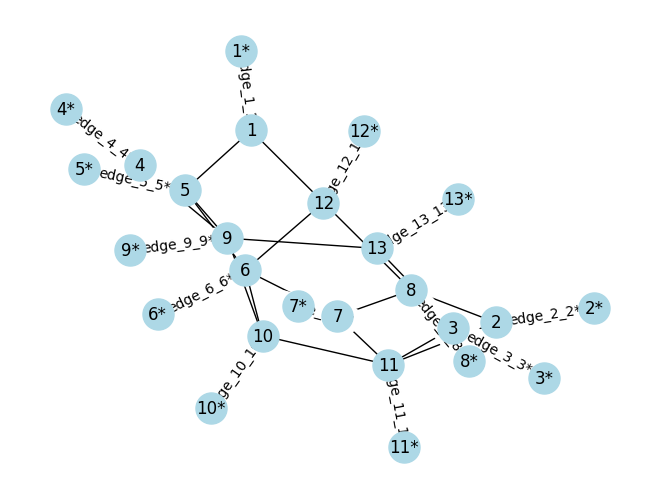

Streaming output truncated to the last 5000 lines.
10016r 9.3447423e+03 3.60e-03 7.41e+02  -6.9 1.75e-01  -1.3 1.88e-02 5.16e-03h  4
10017r 9.3447424e+03 3.58e-03 7.38e+02  -6.9 4.49e-02  -0.9 3.90e-02 2.95e-03h  6
10018r 9.3447424e+03 3.58e-03 7.39e+02  -6.9 2.46e-01  -1.3 2.81e-02 1.37e-04h  6
10019r 9.3447424e+03 3.58e-03 7.38e+02  -6.9 5.06e-02  -0.9 4.06e-02 4.22e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10020r 9.3447429e+03 3.57e-03 7.37e+02  -6.9 3.03e-01  -1.4 1.15e-02 2.85e-03h  1
10021r 9.3447462e+03 3.24e-03 6.75e+02  -6.9 5.77e-02  -1.0 1.66e-01 8.25e-02h  1
10022r 9.3447482e+03 3.03e-03 6.35e+02  -6.9 6.93e-02  -1.4 3.26e-02 5.86e-02h  1
10023r 9.3447606e+03 1.97e-03 4.24e+02  -6.9 4.67e-02  -1.0 1.87e-01 3.31e-01h  1
10024r 9.3447667e+03 1.77e-03 3.85e+02  -6.9 9.25e-02  -1.5 9.99e-02 9.17e-02h  1
10025r 9.3447707e+03 1.31e-03 2.89e+02  -6.9 1.51e-02  -1.1 2.48e-01 2.50e-01f  1
10026r 9.3447872e+03 5.57e-04 2.61e+02  -6.9 3.8

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


Status: warning
q[('w_1', 'path_0')] = 0.7330113186992747
q[('w_1', 'path_1')] = 0.00016655562430541293
q[('w_1', 'path_2')] = 0.2666555700521138
q[('w_1', 'path_3')] = 0.00016655562430542843
q[('w_2', 'path_4')] = 1.692266973668325e-09
q[('w_2', 'path_5')] = 2.1390579757242087e-09
q[('w_2', 'path_6')] = 2.099358644214285e-09
q[('w_2', 'path_7')] = 4.8075649438501274e-15
q[('w_2', 'path_8')] = 2.497428786714002e-09
q[('w_2', 'path_9')] = 1.6922668293106683e-09
q[('w_2', 'path_10')] = 0.0
q[('w_2', 'path_11')] = 0.0
q[('w_2', 'path_12')] = 0.0
q[('w_2', 'path_13')] = 0.0
q[('w_2', 'path_14')] = 2.045122305551869e-10
q[('w_2', 'path_15')] = 0.0
q[('w_2', 'path_16')] = 0.0
q[('w_2', 'path_17')] = 0.0
q[('w_2', 'path_18')] = 0.0
q[('w_2', 'path_19')] = 0.0
q[('w_2', 'path_20')] = 1.0705580233084228e-10
q[('w_2', 'path_21')] = 0.0
q[('w_2', 'path_22')] = 0.37838000207294326
q[('w_2', 'path_23')] = 8.590598197445409e-05
q[('w_2', 'path_24')] = 8.597592021431327e-05
q[('w_2', 'path_25')] = 0.

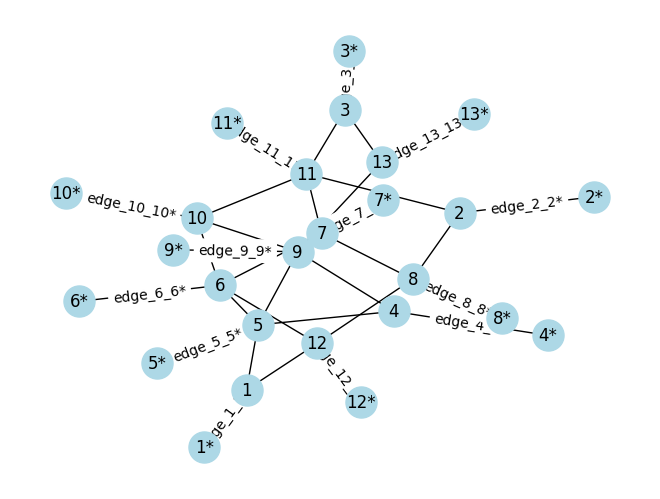

Streaming output truncated to the last 5000 lines.
 723  1.0062368e+04 3.44e-02 1.28e+07  -2.5 1.01e-01    -  2.17e-02 6.44e-03f  1
 724  1.0062393e+04 3.41e-02 1.35e+07  -2.5 9.98e-02    -  1.64e-02 9.73e-03f  1
 725  1.0062394e+04 3.41e-02 1.35e+07  -2.5 9.94e-02    -  2.64e-04 3.31e-04h  1
 726  1.0062424e+04 3.37e-02 1.50e+07  -2.5 1.01e-01    -  1.64e-02 1.19e-02f  1
 727  1.0062424e+04 3.37e-02 2.98e+07  -2.5 8.98e-02    -  2.64e-04 1.09e-04h  1
 728  1.0062446e+04 3.34e-02 2.85e+07  -2.5 9.76e-02    -  5.93e-04 8.93e-03f  1
 729  1.0062461e+04 3.32e-02 2.83e+07  -2.5 9.64e-02    -  7.32e-03 5.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.0062462e+04 3.31e-02 2.83e+07  -2.5 9.35e-02    -  5.10e-04 4.53e-04h  1
 731  1.0062482e+04 3.29e-02 2.81e+07  -2.5 9.58e-02    -  3.25e-02 8.33e-03f  1
 732  1.0062581e+04 3.15e-02 2.69e+07  -2.5 9.58e-02    -  3.35e-03 4.10e-02f  1
 733  1.0062581e+04 3.15e-02 2.69e+07  -2.5 9.09e-02    - 

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


Status: warning
q[('w_1', 'path_0')] = 0.736586002154492
q[('w_1', 'path_1')] = 0.00013150972946041975
q[('w_1', 'path_2')] = 0.2631509783865855
q[('w_1', 'path_3')] = 0.00013150972946041937
q[('w_2', 'path_4')] = 1.8057992087420292e-09
q[('w_2', 'path_5')] = 2.238360681028512e-09
q[('w_2', 'path_6')] = 2.037972858730047e-09
q[('w_2', 'path_7')] = 3.291123429283099e-14
q[('w_2', 'path_8')] = 2.446951881911588e-09
q[('w_2', 'path_9')] = 1.8057991013502903e-09
q[('w_2', 'path_10')] = 0.0
q[('w_2', 'path_11')] = 0.0
q[('w_2', 'path_12')] = 0.0
q[('w_2', 'path_13')] = 0.0
q[('w_2', 'path_14')] = 2.0189135955850142e-10
q[('w_2', 'path_15')] = 0.0
q[('w_2', 'path_16')] = 0.0
q[('w_2', 'path_17')] = 0.0
q[('w_2', 'path_18')] = 0.0
q[('w_2', 'path_19')] = 0.0
q[('w_2', 'path_20')] = 1.0535883246433384e-10
q[('w_2', 'path_21')] = 0.0
q[('w_2', 'path_22')] = 0.35224814508057517
q[('w_2', 'path_23')] = 6.277615092696295e-05
q[('w_2', 'path_24')] = 6.289023926650685e-05
q[('w_2', 'path_25')] = 0.1

In [ ]:

E=[15,11,15,15,7,6,5,7,5,5,5,6,5]
t=t=[10,10,10,10,10,10,10,10,10,10,10,10,10] # price for parking and maintenance

nodes = range(1, 14)  # Example node list
# Parameters
lambda_1 = 1
lambda_2 = 2
lambda_3 = 3
mu = 4  # Service capacity per charger per unit time

B_list= [13,26,39,52]  # Budget for chargers

price_list= [20.6, 23.2, 25.8,
    28.4]  #prices that ensures margin even in the worst case scenario
y_model=[]


W = [(1, 2),(1,3), (4,2), (4,3)
]
predefined_paths_for_w = {
    (1, 2): [[1, 12, 8, 2]],
    (1, 3): [
        [1, 5, 6, 7, 11, 3],
        [1, 12, 6, 10, 11, 3],
        [1, 12, 6, 7, 11, 3],
        [1, 5, 9, 13, 3],
        [1, 5, 6, 10, 11, 3]
    ],
    (4, 2): [
        [4, 5, 6, 7, 8, 2],
        [4, 9, 10, 11, 2]
    ],
    (4, 3): [
        [4, 5, 6, 7, 11, 3],
        [4, 9, 13, 3]
    ]
}

# Initialize lists to store results
x_values_results = []
objective_values = []
q_values_results = []
population=100
charge_rate= 0.15
#y_values= price
edges_with_distances = [
(1, 5, 7, 80.0),
(1, 12, 9, 120.0),
(12, 6, 7, 20.0),
(12, 8, 14, 100.0),
(5, 6, 3, 115.0),
(5, 9, 9, 51.0),
(6, 7, 5, 108.0),
(6, 10, 13, 28.0),
(7, 8, 5, 48.0),
(7, 11, 9, 59.0),
(8, 2, 9, 148.0),
(9, 10, 10, 52.0),
(9, 13, 9, 113.0),
(10, 11, 6, 79.0),
(13, 3, 3, 113.0),
(4, 5, 9, 86.0),
(4, 9, 12, 114.0),
(11, 3, 8, 87.0),
(11, 2, 9, 52.0)
]

    # Extract required data

for price, B in zip(price_list, B_list):
  data = create_graph_and_paths(nodes, edges_with_distances, charge_rate, W, population,predefined_paths_for_w, E, t)
  W_named = data['W_named']
  expanded_paths_with_one_star = data['expanded_paths_with_one_star']
  path_links = data['path_links']
  gamma = data['gamma']
  e = data['e']
  d_l = data['d_l']
  k_l = data['k_l']
  gamma_0_l = data['gamma_0_l']
  T = data['T']
      # Run optimization
  x_values_adjusted = run_optimization(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, price)

      # Run the second optimization with fixed x values and store results
  objective_value, q_values = run_optimization_with_fixed_x(W_named, expanded_paths_with_one_star, path_links, gamma, lambda_1, lambda_2, lambda_3, d_l, k_l, gamma_0_l, mu, B, e, T, x_values_adjusted, price)

      # Store the results

  x_values_results.append(x_values_adjusted)
  objective_values.append(objective_value)
  q_values_results.append(q_values)

  print(f'B: {B}, Objective: {objective_value}')

